/home/abir/miniconda3/lib/python3.13/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


Score        : 5.221
Sequence     : UUUUAAUUAAGGCAGGAGGCGCGGCAGACUUUCUGCCAUGAAUAAUUAAU
Length (nt)  : 50
RBS region   : 13 19
extra_pairs  : 3  pGC: 0.58  loop_len: 9
{'closed_low': 0.916, 'open_midhi': 0.639, 'open_high': 0.835, 'slope70': 0.054, 'reentrant_pen': 0.0}
T50 (≈ 50% open): 72.25 °C | max slope: 0.057 per °C


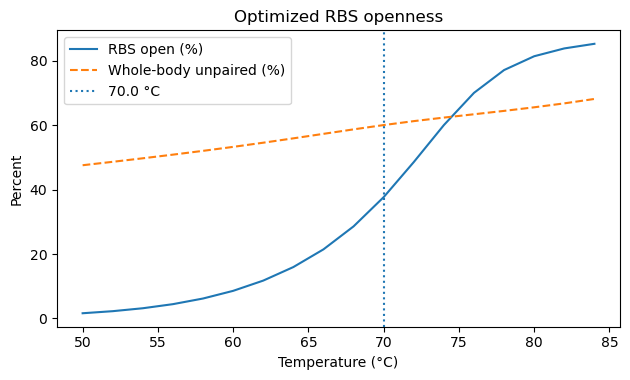

In [1]:
# ==========================================================
# Thermoswitch designer (NUPACK 4, RNA)
# - Hairpin occludes the RBS at low T
# - Anti-RBS softened (few GU wobbles; optional central mismatch)
# - GC-clamped tunable stem; optimize stem length/GC and loop
# - Uses Utilities API: pairs(...) with UNPAIRED = diag(P)
# ==========================================================

import random
import numpy as np
import matplotlib.pyplot as plt
import nupack as nu

# -------------------- Global settings --------------------
TARGET_T = 70.0
LOW_TS   = list(range(50, 70, 2))     # below switch
HIGH_TS  = list(range(72, 86, 2))     # above switch
ALL_TS   = list(range(50, 86, 2))     # temps for scoring/plot
ION_NA   = 1.0                        # M
ION_MG   = 0.0                        # M
DEFAULT_RBS = "AGGAGG"                # Shine–Dalgarno

# -------------------- Small utilities --------------------
COMP = str.maketrans({"A":"U","U":"A","C":"G","G":"C"})
def comp(s): return s.translate(COMP)
def revcomp(s): return comp(s)[::-1]

# -------------------- NUPACK helpers ---------------------
def model_at(c):
    return nu.Model(material="rna", celsius=float(c), sodium=ION_NA, magnesium=ION_MG)

def unpaired_probs(seq, temp_c):
    """
    Per-base UNPAIRED probability using Utilities API.
    For nupack.pairs(), the *diagonal* equals P(unpaired at i).
    """
    pm = nu.pairs(strands=[seq], model=model_at(temp_c))
    P  = pm.to_array()
    return np.diag(P)

def rbs_open(seq, temp_c, rbs_start, rbs_end):
    u  = unpaired_probs(seq, temp_c)
    sl = u[rbs_start:rbs_end]
    return float(np.mean(sl)) if sl.size else np.nan

def rbs_curve(seq, temps, rbs_start, rbs_end):
    return [rbs_open(seq, t, rbs_start, rbs_end) for t in temps]

# ---------- Anti-RBS softener (GU wobbles + optional central mismatch) ----------
def tune_anti_rbs(rbs, wobble_prob=0.20, center_mismatch=False, clamp_ends=True, rng=None):
    """
    Return a softened anti-RBS aligned to RBS (same length).
    - wobble_prob: chance to introduce a GU wobble at any interior pos that allows it
    - center_mismatch: if True, force one full mismatch at the center (helps set Tm sharply)
    - clamp_ends: avoid modifying terminal bases (nucleation clamps)
    """
    if rng is None:
        rng = np.random.default_rng()
    anti = list(revcomp(rbs))  # perfect complement
    L = len(rbs)

    # which positions can we tweak?
    mod_positions = list(range(1, L-1)) if (clamp_ends and L >= 3) else list(range(L))

    # sprinkle GU wobbles
    for i in mod_positions:
        if rng.random() < wobble_prob:
            rb = rbs[i]
            if rb == "G": anti[i] = "U"      # G•U
            elif rb == "U": anti[i] = "G"    # U•G

    # force a single central mismatch if requested
    if center_mismatch and L > 0:
        i = L // 2
        if i in mod_positions:
            choices = [b for b in "AUGC" if b != anti[i]]
            anti[i] = rng.choice(choices)

    return "".join(anti)

# ------------- GC-clamped tunable stem segment -------------
def gc_clamped_extra(n, inner_pGC=0.55):
    """
    n-nt stem segment with GC at ends and tunable GC in the middle.
    Returns "" if n == 0. If n == 1, returns "G".
    """
    if n <= 0: return ""
    if n == 1: return "G"
    mid = "".join(("G" if np.random.rand() < inner_pGC else "A") for _ in range(n-2))
    return "G" + mid + "C"   # GC clamps

# -------------------- Build the scaffold --------------------
def build_switch(
    rbs=DEFAULT_RBS,
    loop_len=6,                 # shorter loop -> stronger OFF
    extra_pairs=3,              # tunable stem pairs flanking RBS
    flank5_len=10, flank3_len=10,
    pGC=0.58,                   # GC bias for *middle* of tunable stem
    spacer_after="AUG",
    wobble_prob=0.20,           # soften anti-RBS lightly
    center_mismatch=False,      # keep OFF tight by default
    clamp_ends=True
):
    """
    5' flank5 + [EXTRA_UP + RBS] + LOOP + [antiRBS_soft + EXTRA_DN] + spacer_after + flank3
    Returns: (sequence, (rbs_start, rbs_end, anti_start, anti_end))
    """
    # GC-clamped tunable stem
    extra_up = gc_clamped_extra(extra_pairs, inner_pGC=pGC)
    extra_dn = revcomp(extra_up)

    left_arm   = extra_up + rbs
    anti_soft  = tune_anti_rbs(rbs, wobble_prob=wobble_prob,
                               center_mismatch=center_mismatch, clamp_ends=clamp_ends)
    right_arm  = anti_soft + extra_dn
    loop       = "".join(random.choice("AUGC") for _ in range(loop_len))

    # AU-rich flanks to avoid off-target pairing
    flank5 = "".join(random.choice("AAAUUUAU") for _ in range(flank5_len))
    flank3 = "".join(random.choice("AAAUUUAU") for _ in range(flank3_len))

    seq = flank5 + left_arm + loop + right_arm + spacer_after + flank3

    rbs_start = len(flank5) + len(extra_up)
    rbs_end   = rbs_start + len(rbs)
    anti_start = len(flank5) + len(left_arm) + len(loop)
    anti_end   = anti_start + len(right_arm)

    return seq, (rbs_start, rbs_end, anti_start, anti_end)

# -------------------- Score “switchiness” --------------------
def switch_score(seq, rbs_start, rbs_end):
    allc = np.array(rbs_curve(seq, ALL_TS, rbs_start, rbs_end))
    t    = np.array(ALL_TS, dtype=float)

    low_mask   = t < 68
    midhi_mask = (t >= 72) & (t <= 78)
    high_mask  = t >= 80

    closed_low = 1.0 - float(np.nanmean(allc[low_mask]))     # OFF below ~68
    open_midhi = float(np.nanmean(allc[midhi_mask]))          # ON just after 70
    open_high  = float(np.nanmean(allc[high_mask]))           # plateau

    diffs = np.diff(allc) / np.diff(t)
    k = int(np.argmin(np.abs(t[:-1] - TARGET_T))) if diffs.size else 0
    slope70 = float(diffs[k]) if diffs.size else 0.0          # steepness at ~70

    # Penalize only if the curve *decreases* anywhere by >2%
    reentrant_pen = 0.3 if np.nanmin(np.diff(allc)) < -0.02 else 0.0

    # Weights: strong OFF + immediate ON + steepness
    score = 2.0*closed_low + 3.0*open_midhi + 1.5*open_high + 4.0*slope70 - reentrant_pen
    parts = dict(closed_low=closed_low, open_midhi=open_midhi,
                 open_high=open_high, slope70=slope70,
                 reentrant_pen=reentrant_pen, curve=allc.tolist())
    return float(score), parts

# ------------- Local search (stem GC/length + loop) -------------
def optimize_switch(rbs=DEFAULT_RBS, restarts=16, steps=90, seed=123,
                    ep_range=(3, 4), pGC_range=(0.55, 0.70), loop_range=(5, 6),
                    wobble_prob=0.10, center_mismatch=False, clamp_ends=True):
    """
    Greedy hill-climb over (extra_pairs, pGC, loop_len) with anti-RBS softening params.
    """
    rng = np.random.default_rng(seed)

    def candidate(ep, pGC, loop):
        seq, (rs, re, _, _) = build_switch(
            rbs=rbs, extra_pairs=int(ep), pGC=float(pGC), loop_len=int(loop),
            wobble_prob=wobble_prob, center_mismatch=center_mismatch, clamp_ends=clamp_ends
        )
        sc, parts = switch_score(seq, rs, re)
        return (sc, seq, rs, re, int(ep), float(pGC), int(loop), parts)

    best = None
    for _ in range(restarts):
        ep   = int(rng.integers(ep_range[0], ep_range[1] + 1))
        pGC  = float(rng.uniform(*pGC_range))
        loop = int(rng.integers(loop_range[0], loop_range[1] + 1))
        cand = candidate(ep, pGC, loop)

        for _ in range(steps):
            ep2   = int(np.clip(ep   + rng.integers(-1, 2), ep_range[0], ep_range[1]))
            pGC2  = float(np.clip(pGC + rng.normal(0, 0.05), pGC_range[0], pGC_range[1]))
            loop2 = int(np.clip(loop + rng.integers(-1, 2), loop_range[0], loop_range[1]))
            trial = candidate(ep2, pGC2, loop2)
            if trial[0] > cand[0]:
                ep, pGC, loop = ep2, pGC2, loop2
                cand = trial

        if best is None or cand[0] > best[0]:
            best = cand

    sc, seq, rs, re, ep, pGC, loop, parts = best
    return dict(score=sc, seq=seq, rbs_start=rs, rbs_end=re,
                extra_pairs=ep, pGC=pGC, loop_len=loop, **parts)

# ------------------------ Analysis helpers ------------------------
def t50_and_maxslope(seq, rbs_start, rbs_end):
    """Return estimated T50 (where openness crosses 0.5) and max slope over ALL_TS."""
    t = np.array(ALL_TS, float)
    y = np.array(rbs_curve(seq, ALL_TS, rbs_start, rbs_end), float)
    idx = np.searchsorted(y, 0.5)
    T50 = np.nan
    if 0 < idx < len(y):
        T50 = t[idx-1] + (0.5 - y[idx-1])*(t[idx]-t[idx-1])/(y[idx]-y[idx-1])
    slope_max = float(np.max(np.diff(y)/np.diff(t)))
    return float(T50), slope_max

def plot_rbs(seq, rbs_start, rbs_end, title="Optimized RBS openness"):
    rbs_opens = rbs_curve(seq, ALL_TS, rbs_start, rbs_end)
    whole = [np.mean(unpaired_probs(seq, t)) for t in ALL_TS]

    plt.figure(figsize=(6.4, 3.9))
    plt.plot(ALL_TS, np.array(rbs_opens)*100, label="RBS open (%)")
    plt.plot(ALL_TS, np.array(whole)*100, linestyle="--", label="Whole-body unpaired (%)")
    plt.axvline(TARGET_T, linestyle=":", label=f"{TARGET_T} °C")
    plt.xlabel("Temperature (°C)"); plt.ylabel("Percent"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

# ------------------------ Example run ------------------------
if __name__ == "__main__":
    random.seed(123); np.random.seed(123)

    # Pass center_mismatch=True if OFF is too tight / ON too late.
    res = optimize_switch(
        rbs=DEFAULT_RBS,
        restarts=14, steps=90, seed=123,
        ep_range=(2, 3),            # shorter stem
        pGC_range=(0.45, 0.58),     # less GC in the middle
        loop_range=(7, 9),          # longer loop = less stable
        wobble_prob=0.30,           # more GU
        center_mismatch=True,       # <-- KEY: destabilize middle of anti-RBS
        clamp_ends=True
)


    print("Score        :", round(res["score"], 3))
    print("Sequence     :", res["seq"])
    print("Length (nt)  :", len(res["seq"]))
    print("RBS region   :", res["rbs_start"], res["rbs_end"])
    print("extra_pairs  :", res["extra_pairs"], " pGC:", round(res["pGC"], 2), " loop_len:", res["loop_len"])
    print({k: round(res[k], 3) for k in ["closed_low","open_midhi","open_high","slope70","reentrant_pen"]})

    T50, smax = t50_and_maxslope(res["seq"], res["rbs_start"], res["rbs_end"])
    print("T50 (≈ 50% open):", None if np.isnan(T50) else round(T50, 2), "°C",
          "| max slope:", round(smax, 3), "per °C")

    plot_rbs(res["seq"], res["rbs_start"], res["rbs_end"])


In [ ]:
# ====== LIBRARY GENERATOR ======
import os, csv
import numpy as np

# Using the SAME parameters we just ran
    ep_range=(2, 3),
    pGC_range=(0.45, 0.58),
    loop_range=(7, 9),
    wobble_prob=0.30,
    center_mismatch=True,  
    clamp_ends=True,
    restarts=14,
    steps=90
)

def _features_from_sequence(seq, rbs_start, rbs_end):
    t = np.array(ALL_TS, float)
    y = np.array(rbs_curve(seq, ALL_TS, rbs_start, rbs_end), float)

    closed_low = float(1.0 - np.nanmean(y[t < 68]))
    open_midhi = float(np.nanmean(y[(t >= 72) & (t <= 78)]))
    open_high  = float(np.nanmean(y[t >= 80]))
    diffs = np.diff(y) / np.diff(t)
    k = int(np.argmin(np.abs(t[:-1] - TARGET_T))) if diffs.size else 0
    slope70 = float(diffs[k]) if diffs.size else 0.0
    # T50 (linear interp)
    idx = int(np.searchsorted(y, 0.5))
    T50 = np.nan
    if 0 < idx < len(y):
        T50 = float(t[idx-1] + (0.5 - y[idx-1])*(t[idx]-t[idx-1])/(y[idx]-y[idx-1]))
    slope_max = float(np.max(diffs)) if diffs.size else 0.0
    reentrant_pen = 0.3 if (np.nanmin(np.diff(y)) < -0.02) else 0.0

    # keeping score consistent with switch_score
    score = 2.0*closed_low + 3.0*open_midhi + 1.5*open_high + 4.0*slope70 - reentrant_pen

    return dict(
        closed_low=closed_low, open_midhi=open_midhi, open_high=open_high,
        slope70=slope70, T50=T50, slope_max=slope_max,
        reentrant_pen=reentrant_pen, score=float(score),
        curve=";".join(f"{v:.6f}" for v in y)
    )

def make_library_csv(out_csv="results/library_10.csv", N=10, seed0=10000):
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    cols = ["id","seq","len","rbs_start","rbs_end","extra_pairs","pGC","loop_len",
            "closed_low","open_midhi","open_high","slope70","T50","slope_max",
            "reentrant_pen","score","curve"]
    with open(out_csv, "w", newline="") as fh:
        w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
        for i in range(N):
            res = optimize_switch(seed=seed0+i, **LIB_PARAMS)
            seq = res["seq"]; rs = res["rbs_start"]; re = res["rbs_end"]
            feats = _features_from_sequence(seq, rs, re)
            row = {
                "id": i, "seq": seq, "len": len(seq),
                "rbs_start": rs, "rbs_end": re,
                "extra_pairs": res.get("extra_pairs",""),
                "pGC": round(float(res.get("pGC", np.nan)), 3),
                "loop_len": res.get("loop_len",""),
                **feats
            }
            w.writerow(row)
    print(f"Wrote {out_csv}")

# generating the library:
make_library_csv("results/library_10.csv", N=10)


In [26]:
# ====== LIBRARY ANALYSIS ======
import csv
import numpy as np
import matplotlib.pyplot as plt

IN_CSV = "results/library_10.csv"

# acceptance criteria 
SPEC = dict(
    min_closed_low = 0.90,   # ≤10% leak below ~68 °C
    min_open_midhi = 0.60,   # ≥60% ON in 72–78 °C
    min_open_high  = 0.80,   # ≥80% ON ≥80 °C
    t50_low        = 69.0,   # T50 window
    t50_high       = 72.5,
    min_slope70    = 0.04
)

def load_rows(path):
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        rows = []
        for d in r:
            # cast types
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len"]:
                d[k] = int(d[k]) if d[k] != "" else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","slope_max","reentrant_pen","score"]:
                d[k] = float(d[k]) if d[k] != "" else np.nan
            rows.append(d)
        return rows

def meets_spec(d):
    return (d["closed_low"] >= SPEC["min_closed_low"] and
            d["open_midhi"] >= SPEC["min_open_midhi"] and
            d["open_high"]  >= SPEC["min_open_high"]  and
            (SPEC["t50_low"] <= d["T50"] <= SPEC["t50_high"]) and
            d["slope70"]    >= SPEC["min_slope70"])

def rank_key(d):
    # best = steep near 70, T50 closest to 70, strong midhi, tight OFF
    return (-d["slope70"], abs(d["T50"]-70.0), -d["open_midhi"], -d["closed_low"])

def plot_top(rows, k=5):
    t = np.array(ALL_TS, float)
    plt.figure(figsize=(7.0, 4.0))
    for i, d in enumerate(rows[:k], 1):
        y = np.array([float(v) for v in d["curve"].split(";")])
        plt.plot(t, y*100, label=f"{i}) id={d['id']} T50={d['T50']:.1f}, leak={1-d['closed_low']:.2f}")
    plt.axvline(70, ls=":", color="k", alpha=0.6)
    plt.xlabel("Temperature (°C)"); plt.ylabel("RBS open (%)")
    plt.title(f"Top {min(k, len(rows))} sequences"); plt.legend(); plt.tight_layout(); plt.show()

rows = load_rows(IN_CSV)
hits = [d for d in rows if meets_spec(d)]
hits.sort(key=rank_key)

print(f"Total designs: {len(rows)}  |  Meets spec: {len(hits)}")
if hits:
    best = hits[0]
    print("Top pick:",
          f"id={best['id']}, len={best['len']}, T50={best['T50']:.2f}°C,",
          f"leak={1-best['closed_low']:.02f}, midhi={best['open_midhi']:.2f},",
          f"high={best['open_high']:.2f}, slope70={best['slope70']:.3f}")
    plot_top(hits, k=5)
else:
    print("No sequences met the spec — widen the window slightly and re-run.")


Total designs: 0  |  Meets spec: 0
No sequences met the spec — widen the window slightly and re-run.


In [24]:
# ====== LIBRARY GENERATOR ======
import os, csv
import numpy as np

# Using the SAME parameters we just ran
LIB_PARAMS = dict(
    ep_range=(2, 3),
    pGC_range=(0.45, 0.58),
    loop_range=(7, 9),
    wobble_prob=0.30,
    center_mismatch=True,   
    clamp_ends=True,
    restarts=14,
    steps=90
)

def _features_from_sequence(seq, rbs_start, rbs_end):
    t = np.array(ALL_TS, float)
    y = np.array(rbs_curve(seq, ALL_TS, rbs_start, rbs_end), float)

    closed_low = float(1.0 - np.nanmean(y[t < 68]))
    open_midhi = float(np.nanmean(y[(t >= 72) & (t <= 78)]))
    open_high  = float(np.nanmean(y[t >= 80]))
    diffs = np.diff(y) / np.diff(t)
    k = int(np.argmin(np.abs(t[:-1] - TARGET_T))) if diffs.size else 0
    slope70 = float(diffs[k]) if diffs.size else 0.0
    # T50 (linear interp)
    idx = int(np.searchsorted(y, 0.5))
    T50 = np.nan
    if 0 < idx < len(y):
        T50 = float(t[idx-1] + (0.5 - y[idx-1])*(t[idx]-t[idx-1])/(y[idx]-y[idx-1]))
    slope_max = float(np.max(diffs)) if diffs.size else 0.0
    reentrant_pen = 0.3 if (np.nanmin(np.diff(y)) < -0.02) else 0.0

    # keeps score consistent with switch_score
    score = 2.0*closed_low + 3.0*open_midhi + 1.5*open_high + 4.0*slope70 - reentrant_pen

    return dict(
        closed_low=closed_low, open_midhi=open_midhi, open_high=open_high,
        slope70=slope70, T50=T50, slope_max=slope_max,
        reentrant_pen=reentrant_pen, score=float(score),
        curve=";".join(f"{v:.6f}" for v in y)
    )

def make_library_csv(out_csv="results/library_10.csv", N=10, seed0=10000):
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    cols = ["id","seq","len","rbs_start","rbs_end","extra_pairs","pGC","loop_len",
            "closed_low","open_midhi","open_high","slope70","T50","slope_max",
            "reentrant_pen","score","curve"]
    with open(out_csv, "w", newline="") as fh:
        w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
        for i in range(N):
            res = optimize_switch(seed=seed0+i, **LIB_PARAMS)
            seq = res["seq"]; rs = res["rbs_start"]; re = res["rbs_end"]
            feats = _features_from_sequence(seq, rs, re)
            row = {
                "id": i, "seq": seq, "len": len(seq),
                "rbs_start": rs, "rbs_end": re,
                "extra_pairs": res.get("extra_pairs",""),
                "pGC": round(float(res.get("pGC", np.nan)), 3),
                "loop_len": res.get("loop_len",""),
                **feats
            }
            w.writerow(row)
    print(f"Wrote {out_csv}")

make_library_csv("results/library_100.csv", N=100)


Wrote results/library_100.csv


In [2]:
# ===== ML harness for the big CSV =====
import os, csv, numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score

CSV_PATH = "results/library_100.csv"   # <-- change if different

SPEC = dict(  # same spec you used before
    min_closed_low = 0.90,
    min_open_midhi = 0.60,
    min_open_high  = 0.80,
    t50_low        = 69.0,
    t50_high       = 72.5,
    min_slope70    = 0.04
)

ALPH = "AUGC"
DINUCS = [a+b for a in ALPH for b in ALPH]  # 16-dim

def meets_spec(d):
    return (d["closed_low"]>=SPEC["min_closed_low"] and
            d["open_midhi"]>=SPEC["min_open_midhi"] and
            d["open_high"] >=SPEC["min_open_high"]  and
            SPEC["t50_low"]<=d["T50"]<=SPEC["t50_high"] and
            d["slope70"]   >=SPEC["min_slope70"])

def load_rows(path):
    rows = []
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        for d in r:
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len"]:
                d[k] = int(d[k]) if d.get(k,"") != "" else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","score"]:
                d[k] = float(d[k]) if d.get(k,"") != "" else np.nan
            rows.append(d)
    return rows

def dinuc_freqs(seq):
    cnt = Counter(seq[i:i+2] for i in range(len(seq)-1))
    total = max(1, len(seq)-1)
    return np.array([cnt.get(m,0)/total for m in DINUCS], float)

def make_features(row):
    seq = row["seq"]; L = len(seq)
    gc  = (seq.count("G")+seq.count("C"))/L
    ep  = row.get("extra_pairs") or 0
    pGC = row.get("pGC", 0.0) if not np.isnan(row.get("pGC", np.nan)) else 0.0
    loop= row.get("loop_len") or 0
    return np.array([L, gc, ep, pGC, loop, *dinuc_freqs(seq)], float)

# ---- load & build dataset ----
rows = load_rows(CSV_PATH)
X = np.vstack([make_features(d) for d in rows])
y_cls = np.array([int(meets_spec(d)) for d in rows], int)
Y_t50 = np.array([d["T50"] for d in rows], float)
Y_slp = np.array([d["slope70"] for d in rows], float)

# ---- split (stratify on pass/fail) ----
Xtr, Xte, ytr, yte, t50_tr, t50_te, slp_tr, slp_te, rows_tr, rows_te = train_test_split(
    X, y_cls, Y_t50, Y_slp, rows, test_size=0.2, random_state=42, stratify=y_cls
)

# ---- classifier ----
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
clf.fit(Xtr, ytr)
probs = clf.predict_proba(Xte)[:,1]
preds = (probs >= 0.5).astype(int)
print(f"Classifier  | ROC-AUC={roc_auc_score(yte, probs):.3f}  PR-AUC={average_precision_score(yte, probs):.3f}")
print(classification_report(yte, preds, digits=3))

# ---- regressors ----
reg_t50 = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=400, random_state=0, n_jobs=-1))
reg_slp = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=400, random_state=1, n_jobs=-1))
reg_t50.fit(Xtr, t50_tr); reg_slp.fit(Xtr, slp_tr)

t50_hat = reg_t50.predict(Xte)
slp_hat = reg_slp.predict(Xte)
print(f"T50   reg   | MAE={mean_absolute_error(t50_te, t50_hat):.3f}  R2={r2_score(t50_te, t50_hat):.3f}")
print(f"slope reg   | MAE={mean_absolute_error(slp_te, slp_hat):.3f}  R2={r2_score(slp_te, slp_hat):.3f}")

# ---- score all rows, rank, and save top-50 ----
all_probs = clf.predict_proba(X)[:,1]
all_t50   = reg_t50.predict(X)
all_slope = reg_slp.predict(X)

def score_row(i):
    d = rows[i]
    # same score shape, but use predicted T50/slope along with measured features when ranking new ones
    # here we'll rank by P(pass) primarily, then by predicted slope near 70 and T50 closeness
    return (all_probs[i], -abs(all_t50[i]-70.0), all_slope[i], d.get("open_midhi",0.0))

rank_idx = sorted(range(len(rows)), key=lambda i: score_row(i), reverse=True)
topk = rank_idx[:50]

os.makedirs("results", exist_ok=True)
# save predictions for all
with open("results/ml_predictions.csv", "w", newline="") as fh:
    cols = ["id","seq","len","p_pass","t50_pred","slope70_pred","closed_low","open_midhi","open_high","T50","slope70"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for i in range(len(rows)):
        d = rows[i]
        w.writerow(dict(id=d["id"], seq=d["seq"], len=len(d["seq"]),
                        p_pass=float(all_probs[i]), t50_pred=float(all_t50[i]), slope70_pred=float(all_slope[i]),
                        closed_low=d["closed_low"], open_midhi=d["open_midhi"], open_high=d["open_high"],
                        T50=d["T50"], slope70=d["slope70"]))

print("Wrote results/ml_predictions.csv")


Classifier  | ROC-AUC=0.333  PR-AUC=0.109
              precision    recall  f1-score   support

           0      0.889     0.889     0.889        18
           1      0.000     0.000     0.000         2

    accuracy                          0.800        20
   macro avg      0.444     0.444     0.444        20
weighted avg      0.800     0.800     0.800        20

T50   reg   | MAE=1.001  R2=0.112
slope reg   | MAE=0.006  R2=-0.026
Wrote results/ml_predictions.csv


Total designs: 100  |  Meets spec: 12
Top pick: id=40, len=48, T50=71.20°C, leak=0.07, midhi=0.69, high=0.81, slope70=0.064


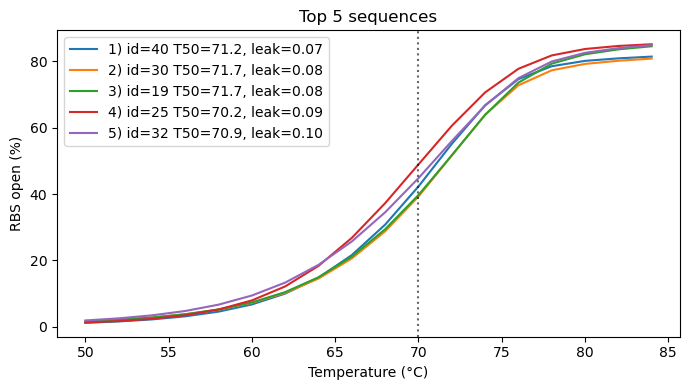

In [27]:
# ====== LIBRARY ANALYSIS ======
import csv
import numpy as np
import matplotlib.pyplot as plt

IN_CSV = "results/library_100.csv"

# acceptance criteria (tweak to match your target)
SPEC = dict(
    min_closed_low = 0.90,   # ≤10% leak below ~68 °C
    min_open_midhi = 0.60,   # ≥60% ON in 72–78 °C
    min_open_high  = 0.80,   # ≥80% ON ≥80 °C
    t50_low        = 69.0,   # T50 window
    t50_high       = 72.5,
    min_slope70    = 0.04
)

def load_rows(path):
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        rows = []
        for d in r:
            # cast types
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len"]:
                d[k] = int(d[k]) if d[k] != "" else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","slope_max","reentrant_pen","score"]:
                d[k] = float(d[k]) if d[k] != "" else np.nan
            rows.append(d)
        return rows

def meets_spec(d):
    return (d["closed_low"] >= SPEC["min_closed_low"] and
            d["open_midhi"] >= SPEC["min_open_midhi"] and
            d["open_high"]  >= SPEC["min_open_high"]  and
            (SPEC["t50_low"] <= d["T50"] <= SPEC["t50_high"]) and
            d["slope70"]    >= SPEC["min_slope70"])

def rank_key(d):
    # best = steep near 70, T50 closest to 70, strong midhi, tight OFF
    return (-d["slope70"], abs(d["T50"]-70.0), -d["open_midhi"], -d["closed_low"])

def plot_top(rows, k=5):
    t = np.array(ALL_TS, float)
    plt.figure(figsize=(7.0, 4.0))
    for i, d in enumerate(rows[:k], 1):
        y = np.array([float(v) for v in d["curve"].split(";")])
        plt.plot(t, y*100, label=f"{i}) id={d['id']} T50={d['T50']:.1f}, leak={1-d['closed_low']:.2f}")
    plt.axvline(70, ls=":", color="k", alpha=0.6)
    plt.xlabel("Temperature (°C)"); plt.ylabel("RBS open (%)")
    plt.title(f"Top {min(k, len(rows))} sequences"); plt.legend(); plt.tight_layout(); plt.show()

rows = load_rows(IN_CSV)
hits = [d for d in rows if meets_spec(d)]
hits.sort(key=rank_key)

print(f"Total designs: {len(rows)}  |  Meets spec: {len(hits)}")
if hits:
    best = hits[0]
    print("Top pick:",
          f"id={best['id']}, len={best['len']}, T50={best['T50']:.2f}°C,",
          f"leak={1-best['closed_low']:.02f}, midhi={best['open_midhi']:.2f},",
          f"high={best['open_high']:.2f}, slope70={best['slope70']:.3f}")
    plot_top(hits, k=5)
else:
    print("No sequences met the spec — widen the window slightly and re-run.")


In [28]:
# ====== LIBRARY GENERATOR ======
import os, csv
import numpy as np

# Using the SAME parameters you just ran
LIB_PARAMS = dict(
    ep_range=(2, 3),
    pGC_range=(0.45, 0.58),
    loop_range=(7, 9),
    wobble_prob=0.30,
    center_mismatch=True,  
    clamp_ends=True,
    restarts=14,
    steps=90
)

def _features_from_sequence(seq, rbs_start, rbs_end):
    t = np.array(ALL_TS, float)
    y = np.array(rbs_curve(seq, ALL_TS, rbs_start, rbs_end), float)

    closed_low = float(1.0 - np.nanmean(y[t < 68]))
    open_midhi = float(np.nanmean(y[(t >= 72) & (t <= 78)]))
    open_high  = float(np.nanmean(y[t >= 80]))
    diffs = np.diff(y) / np.diff(t)
    k = int(np.argmin(np.abs(t[:-1] - TARGET_T))) if diffs.size else 0
    slope70 = float(diffs[k]) if diffs.size else 0.0
    # T50 (linear interp)
    idx = int(np.searchsorted(y, 0.5))
    T50 = np.nan
    if 0 < idx < len(y):
        T50 = float(t[idx-1] + (0.5 - y[idx-1])*(t[idx]-t[idx-1])/(y[idx]-y[idx-1]))
    slope_max = float(np.max(diffs)) if diffs.size else 0.0
    reentrant_pen = 0.3 if (np.nanmin(np.diff(y)) < -0.02) else 0.0

    # keeping score consistent with switch_score
    score = 2.0*closed_low + 3.0*open_midhi + 1.5*open_high + 4.0*slope70 - reentrant_pen

    return dict(
        closed_low=closed_low, open_midhi=open_midhi, open_high=open_high,
        slope70=slope70, T50=T50, slope_max=slope_max,
        reentrant_pen=reentrant_pen, score=float(score),
        curve=";".join(f"{v:.6f}" for v in y)
    )

def make_library_csv(out_csv="results/library_10.csv", N=10, seed0=10000):
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    cols = ["id","seq","len","rbs_start","rbs_end","extra_pairs","pGC","loop_len",
            "closed_low","open_midhi","open_high","slope70","T50","slope_max",
            "reentrant_pen","score","curve"]
    with open(out_csv, "w", newline="") as fh:
        w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
        for i in range(N):
            res = optimize_switch(seed=seed0+i, **LIB_PARAMS)
            seq = res["seq"]; rs = res["rbs_start"]; re = res["rbs_end"]
            feats = _features_from_sequence(seq, rs, re)
            row = {
                "id": i, "seq": seq, "len": len(seq),
                "rbs_start": rs, "rbs_end": re,
                "extra_pairs": res.get("extra_pairs",""),
                "pGC": round(float(res.get("pGC", np.nan)), 3),
                "loop_len": res.get("loop_len",""),
                **feats
            }
            w.writerow(row)
    print(f"Wrote {out_csv}")

# run it:
make_library_csv("results/library2_100.csv", N=100)


Wrote results/library2_100.csv


In [29]:
# ====== LIBRARY GENERATOR ======
import os, csv
import numpy as np

# Use the SAME parameters you just ran (edit here if you want the no-mismatch preset)
LIB_PARAMS = dict(
    ep_range=(2, 3),
    pGC_range=(0.45, 0.58),
    loop_range=(7, 9),
    wobble_prob=0.30,
    center_mismatch=True,   # <- set False if you want the low-leak preset
    clamp_ends=True,
    restarts=14,
    steps=90
)

def _features_from_sequence(seq, rbs_start, rbs_end):
    t = np.array(ALL_TS, float)
    y = np.array(rbs_curve(seq, ALL_TS, rbs_start, rbs_end), float)

    closed_low = float(1.0 - np.nanmean(y[t < 68]))
    open_midhi = float(np.nanmean(y[(t >= 72) & (t <= 78)]))
    open_high  = float(np.nanmean(y[t >= 80]))
    diffs = np.diff(y) / np.diff(t)
    k = int(np.argmin(np.abs(t[:-1] - TARGET_T))) if diffs.size else 0
    slope70 = float(diffs[k]) if diffs.size else 0.0
    # T50 (linear interp)
    idx = int(np.searchsorted(y, 0.5))
    T50 = np.nan
    if 0 < idx < len(y):
        T50 = float(t[idx-1] + (0.5 - y[idx-1])*(t[idx]-t[idx-1])/(y[idx]-y[idx-1]))
    slope_max = float(np.max(diffs)) if diffs.size else 0.0
    reentrant_pen = 0.3 if (np.nanmin(np.diff(y)) < -0.02) else 0.0

    # keep score consistent with switch_score
    score = 2.0*closed_low + 3.0*open_midhi + 1.5*open_high + 4.0*slope70 - reentrant_pen

    return dict(
        closed_low=closed_low, open_midhi=open_midhi, open_high=open_high,
        slope70=slope70, T50=T50, slope_max=slope_max,
        reentrant_pen=reentrant_pen, score=float(score),
        curve=";".join(f"{v:.6f}" for v in y)
    )

def make_library_csv(out_csv="results/library_10.csv", N=10, seed0=10000):
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    cols = ["id","seq","len","rbs_start","rbs_end","extra_pairs","pGC","loop_len",
            "closed_low","open_midhi","open_high","slope70","T50","slope_max",
            "reentrant_pen","score","curve"]
    with open(out_csv, "w", newline="") as fh:
        w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
        for i in range(N):
            res = optimize_switch(seed=seed0+i, **LIB_PARAMS)
            seq = res["seq"]; rs = res["rbs_start"]; re = res["rbs_end"]
            feats = _features_from_sequence(seq, rs, re)
            row = {
                "id": i, "seq": seq, "len": len(seq),
                "rbs_start": rs, "rbs_end": re,
                "extra_pairs": res.get("extra_pairs",""),
                "pGC": round(float(res.get("pGC", np.nan)), 3),
                "loop_len": res.get("loop_len",""),
                **feats
            }
            w.writerow(row)
    print(f"Wrote {out_csv}")

# run it:
make_library_csv("results/library3_200.csv", N=200)


Wrote results/library3_200.csv


In [30]:
# ====== LIBRARY GENERATOR ======
import os, csv
import numpy as np

# Use the SAME parameters you just ran (edit here if you want the no-mismatch preset)
LIB_PARAMS = dict(
    ep_range=(2, 3),
    pGC_range=(0.45, 0.58),
    loop_range=(7, 9),
    wobble_prob=0.30,
    center_mismatch=True,   # <- set False if you want the low-leak preset
    clamp_ends=True,
    restarts=14,
    steps=90
)

def _features_from_sequence(seq, rbs_start, rbs_end):
    t = np.array(ALL_TS, float)
    y = np.array(rbs_curve(seq, ALL_TS, rbs_start, rbs_end), float)

    closed_low = float(1.0 - np.nanmean(y[t < 68]))
    open_midhi = float(np.nanmean(y[(t >= 72) & (t <= 78)]))
    open_high  = float(np.nanmean(y[t >= 80]))
    diffs = np.diff(y) / np.diff(t)
    k = int(np.argmin(np.abs(t[:-1] - TARGET_T))) if diffs.size else 0
    slope70 = float(diffs[k]) if diffs.size else 0.0
    # T50 (linear interp)
    idx = int(np.searchsorted(y, 0.5))
    T50 = np.nan
    if 0 < idx < len(y):
        T50 = float(t[idx-1] + (0.5 - y[idx-1])*(t[idx]-t[idx-1])/(y[idx]-y[idx-1]))
    slope_max = float(np.max(diffs)) if diffs.size else 0.0
    reentrant_pen = 0.3 if (np.nanmin(np.diff(y)) < -0.02) else 0.0

    # keep score consistent with switch_score
    score = 2.0*closed_low + 3.0*open_midhi + 1.5*open_high + 4.0*slope70 - reentrant_pen

    return dict(
        closed_low=closed_low, open_midhi=open_midhi, open_high=open_high,
        slope70=slope70, T50=T50, slope_max=slope_max,
        reentrant_pen=reentrant_pen, score=float(score),
        curve=";".join(f"{v:.6f}" for v in y)
    )

def make_library_csv(out_csv="results/library_10.csv", N=10, seed0=10000):
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    cols = ["id","seq","len","rbs_start","rbs_end","extra_pairs","pGC","loop_len",
            "closed_low","open_midhi","open_high","slope70","T50","slope_max",
            "reentrant_pen","score","curve"]
    with open(out_csv, "w", newline="") as fh:
        w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
        for i in range(N):
            res = optimize_switch(seed=seed0+i, **LIB_PARAMS)
            seq = res["seq"]; rs = res["rbs_start"]; re = res["rbs_end"]
            feats = _features_from_sequence(seq, rs, re)
            row = {
                "id": i, "seq": seq, "len": len(seq),
                "rbs_start": rs, "rbs_end": re,
                "extra_pairs": res.get("extra_pairs",""),
                "pGC": round(float(res.get("pGC", np.nan)), 3),
                "loop_len": res.get("loop_len",""),
                **feats
            }
            w.writerow(row)
    print(f"Wrote {out_csv}")

# run it:
make_library_csv("results/library4_300.csv", N=300)


Wrote results/library4_300.csv


Total designs: 300  |  Meets spec: 56
Top pick: id=58, len=48, T50=71.69°C, leak=0.06, midhi=0.69, high=0.84, slope70=0.072


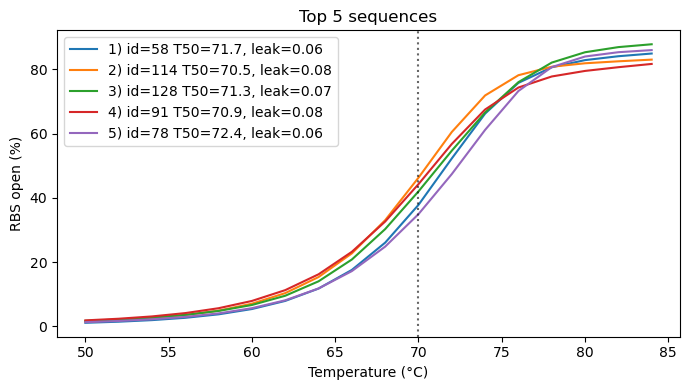

In [31]:
# ====== LIBRARY ANALYSIS ======
import csv
import numpy as np
import matplotlib.pyplot as plt

IN_CSV = "results/library4_300.csv"

# acceptance criteria (tweak to match our target)
SPEC = dict(
    min_closed_low = 0.90,   # ≤10% leak below ~68 °C
    min_open_midhi = 0.60,   # ≥60% ON in 72–78 °C
    min_open_high  = 0.80,   # ≥80% ON ≥80 °C
    t50_low        = 69.0,   # T50 window
    t50_high       = 72.5,
    min_slope70    = 0.04
)

def load_rows(path):
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        rows = []
        for d in r:
            # cast types
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len"]:
                d[k] = int(d[k]) if d[k] != "" else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","slope_max","reentrant_pen","score"]:
                d[k] = float(d[k]) if d[k] != "" else np.nan
            rows.append(d)
        return rows

def meets_spec(d):
    return (d["closed_low"] >= SPEC["min_closed_low"] and
            d["open_midhi"] >= SPEC["min_open_midhi"] and
            d["open_high"]  >= SPEC["min_open_high"]  and
            (SPEC["t50_low"] <= d["T50"] <= SPEC["t50_high"]) and
            d["slope70"]    >= SPEC["min_slope70"])

def rank_key(d):
    # best = steep near 70, T50 closest to 70, strong midhi, tight OFF
    return (-d["slope70"], abs(d["T50"]-70.0), -d["open_midhi"], -d["closed_low"])

def plot_top(rows, k=5):
    t = np.array(ALL_TS, float)
    plt.figure(figsize=(7.0, 4.0))
    for i, d in enumerate(rows[:k], 1):
        y = np.array([float(v) for v in d["curve"].split(";")])
        plt.plot(t, y*100, label=f"{i}) id={d['id']} T50={d['T50']:.1f}, leak={1-d['closed_low']:.2f}")
    plt.axvline(70, ls=":", color="k", alpha=0.6)
    plt.xlabel("Temperature (°C)"); plt.ylabel("RBS open (%)")
    plt.title(f"Top {min(k, len(rows))} sequences"); plt.legend(); plt.tight_layout(); plt.show()

rows = load_rows(IN_CSV)
hits = [d for d in rows if meets_spec(d)]
hits.sort(key=rank_key)

print(f"Total designs: {len(rows)}  |  Meets spec: {len(hits)}")
if hits:
    best = hits[0]
    print("Top pick:",
          f"id={best['id']}, len={best['len']}, T50={best['T50']:.2f}°C,",
          f"leak={1-best['closed_low']:.02f}, midhi={best['open_midhi']:.2f},",
          f"high={best['open_high']:.2f}, slope70={best['slope70']:.3f}")
    plot_top(hits, k=5)
else:
    print("No sequences met the spec — widen the window slightly and re-run.")


Total designs: 100  |  Meets spec: 14
Top pick: id=35, len=48, T50=71.23°C, leak=0.07, midhi=0.71, high=0.83, slope70=0.075


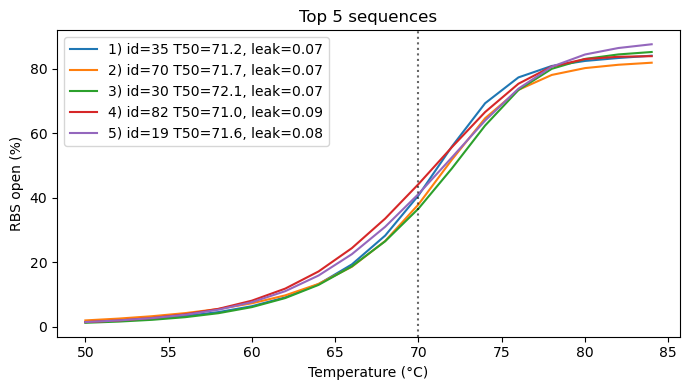

In [4]:
# ====== LIBRARY ANALYSIS ======
import csv
import numpy as np
import matplotlib.pyplot as plt

IN_CSV = "results/library2_100.csv"

# acceptance criteria (tweak to match our target)
SPEC = dict(
    min_closed_low = 0.90,   # ≤10% leak below ~68 °C
    min_open_midhi = 0.60,   # ≥60% ON in 72–78 °C
    min_open_high  = 0.80,   # ≥80% ON ≥80 °C
    t50_low        = 69.0,   # T50 window
    t50_high       = 72.5,
    min_slope70    = 0.04
)

def load_rows(path):
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        rows = []
        for d in r:
            # cast types
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len"]:
                d[k] = int(d[k]) if d[k] != "" else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","slope_max","reentrant_pen","score"]:
                d[k] = float(d[k]) if d[k] != "" else np.nan
            rows.append(d)
        return rows

def meets_spec(d):
    return (d["closed_low"] >= SPEC["min_closed_low"] and
            d["open_midhi"] >= SPEC["min_open_midhi"] and
            d["open_high"]  >= SPEC["min_open_high"]  and
            (SPEC["t50_low"] <= d["T50"] <= SPEC["t50_high"]) and
            d["slope70"]    >= SPEC["min_slope70"])

def rank_key(d):
    # best = steep near 70, T50 closest to 70, strong midhi, tight OFF
    return (-d["slope70"], abs(d["T50"]-70.0), -d["open_midhi"], -d["closed_low"])

def plot_top(rows, k=5):
    t = np.array(ALL_TS, float)
    plt.figure(figsize=(7.0, 4.0))
    for i, d in enumerate(rows[:k], 1):
        y = np.array([float(v) for v in d["curve"].split(";")])
        plt.plot(t, y*100, label=f"{i}) id={d['id']} T50={d['T50']:.1f}, leak={1-d['closed_low']:.2f}")
    plt.axvline(70, ls=":", color="k", alpha=0.6)
    plt.xlabel("Temperature (°C)"); plt.ylabel("RBS open (%)")
    plt.title(f"Top {min(k, len(rows))} sequences"); plt.legend(); plt.tight_layout(); plt.show()

rows = load_rows(IN_CSV)
hits = [d for d in rows if meets_spec(d)]
hits.sort(key=rank_key)

print(f"Total designs: {len(rows)}  |  Meets spec: {len(hits)}")
if hits:
    best = hits[0]
    print("Top pick:",
          f"id={best['id']}, len={best['len']}, T50={best['T50']:.2f}°C,",
          f"leak={1-best['closed_low']:.02f}, midhi={best['open_midhi']:.2f},",
          f"high={best['open_high']:.2f}, slope70={best['slope70']:.3f}")
    plot_top(hits, k=5)
else:
    print("No sequences met the spec — widen the window slightly and re-run.")


Total designs: 200  |  Meets spec: 30
Top pick: id=166, len=48, T50=71.79°C, leak=0.05, midhi=0.67, high=0.82, slope70=0.070


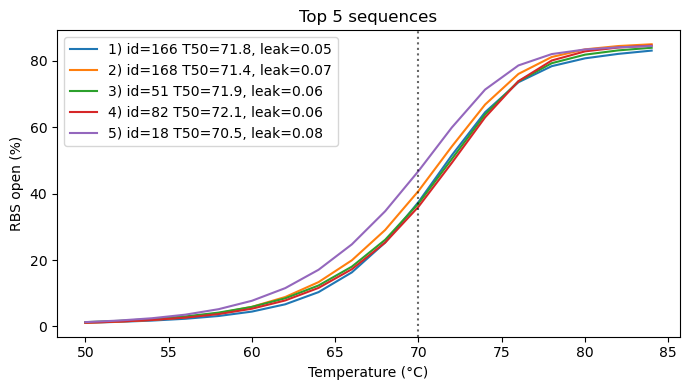

In [5]:
# ====== LIBRARY ANALYSIS ======
import csv
import numpy as np
import matplotlib.pyplot as plt

IN_CSV = "results/library3_200.csv"

# acceptance criteria (tweak to match our target)
SPEC = dict(
    min_closed_low = 0.90,   # ≤10% leak below ~68 °C
    min_open_midhi = 0.60,   # ≥60% ON in 72–78 °C
    min_open_high  = 0.80,   # ≥80% ON ≥80 °C
    t50_low        = 69.0,   # T50 window
    t50_high       = 72.5,
    min_slope70    = 0.04
)

def load_rows(path):
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        rows = []
        for d in r:
            # cast types
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len"]:
                d[k] = int(d[k]) if d[k] != "" else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","slope_max","reentrant_pen","score"]:
                d[k] = float(d[k]) if d[k] != "" else np.nan
            rows.append(d)
        return rows

def meets_spec(d):
    return (d["closed_low"] >= SPEC["min_closed_low"] and
            d["open_midhi"] >= SPEC["min_open_midhi"] and
            d["open_high"]  >= SPEC["min_open_high"]  and
            (SPEC["t50_low"] <= d["T50"] <= SPEC["t50_high"]) and
            d["slope70"]    >= SPEC["min_slope70"])

def rank_key(d):
    # best = steep near 70, T50 closest to 70, strong midhi, tight OFF
    return (-d["slope70"], abs(d["T50"]-70.0), -d["open_midhi"], -d["closed_low"])

def plot_top(rows, k=5):
    t = np.array(ALL_TS, float)
    plt.figure(figsize=(7.0, 4.0))
    for i, d in enumerate(rows[:k], 1):
        y = np.array([float(v) for v in d["curve"].split(";")])
        plt.plot(t, y*100, label=f"{i}) id={d['id']} T50={d['T50']:.1f}, leak={1-d['closed_low']:.2f}")
    plt.axvline(70, ls=":", color="k", alpha=0.6)
    plt.xlabel("Temperature (°C)"); plt.ylabel("RBS open (%)")
    plt.title(f"Top {min(k, len(rows))} sequences"); plt.legend(); plt.tight_layout(); plt.show()

rows = load_rows(IN_CSV)
hits = [d for d in rows if meets_spec(d)]
hits.sort(key=rank_key)

print(f"Total designs: {len(rows)}  |  Meets spec: {len(hits)}")
if hits:
    best = hits[0]
    print("Top pick:",
          f"id={best['id']}, len={best['len']}, T50={best['T50']:.2f}°C,",
          f"leak={1-best['closed_low']:.02f}, midhi={best['open_midhi']:.2f},",
          f"high={best['open_high']:.2f}, slope70={best['slope70']:.3f}")
    plot_top(hits, k=5)
else:
    print("No sequences met the spec — widen the window slightly and re-run.")


In [3]:
# ===== ML harness for the big CSV =====
import os, csv, numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score

CSV_PATH = "results/library_combined.csv"   # <-- change if different

SPEC = dict(  # same spec you used before
    min_closed_low = 0.90,
    min_open_midhi = 0.60,
    min_open_high  = 0.80,
    t50_low        = 69.0,
    t50_high       = 72.5,
    min_slope70    = 0.04
)

ALPH = "AUGC"
DINUCS = [a+b for a in ALPH for b in ALPH]  # 16-dim

def meets_spec(d):
    return (d["closed_low"]>=SPEC["min_closed_low"] and
            d["open_midhi"]>=SPEC["min_open_midhi"] and
            d["open_high"] >=SPEC["min_open_high"]  and
            SPEC["t50_low"]<=d["T50"]<=SPEC["t50_high"] and
            d["slope70"]   >=SPEC["min_slope70"])

def load_rows(path):
    rows = []
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        for d in r:
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len"]:
                d[k] = int(d[k]) if d.get(k,"") != "" else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","score"]:
                d[k] = float(d[k]) if d.get(k,"") != "" else np.nan
            rows.append(d)
    return rows

def dinuc_freqs(seq):
    cnt = Counter(seq[i:i+2] for i in range(len(seq)-1))
    total = max(1, len(seq)-1)
    return np.array([cnt.get(m,0)/total for m in DINUCS], float)

def make_features(row):
    seq = row["seq"]; L = len(seq)
    gc  = (seq.count("G")+seq.count("C"))/L
    ep  = row.get("extra_pairs") or 0
    pGC = row.get("pGC", 0.0) if not np.isnan(row.get("pGC", np.nan)) else 0.0
    loop= row.get("loop_len") or 0
    return np.array([L, gc, ep, pGC, loop, *dinuc_freqs(seq)], float)

# ---- load & build dataset ----
rows = load_rows(CSV_PATH)
X = np.vstack([make_features(d) for d in rows])
y_cls = np.array([int(meets_spec(d)) for d in rows], int)
Y_t50 = np.array([d["T50"] for d in rows], float)
Y_slp = np.array([d["slope70"] for d in rows], float)

# ---- split (stratify on pass/fail) ----
Xtr, Xte, ytr, yte, t50_tr, t50_te, slp_tr, slp_te, rows_tr, rows_te = train_test_split(
    X, y_cls, Y_t50, Y_slp, rows, test_size=0.2, random_state=42, stratify=y_cls
)

# ---- classifier ----
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
clf.fit(Xtr, ytr)
probs = clf.predict_proba(Xte)[:,1]
preds = (probs >= 0.5).astype(int)
print(f"Classifier  | ROC-AUC={roc_auc_score(yte, probs):.3f}  PR-AUC={average_precision_score(yte, probs):.3f}")
print(classification_report(yte, preds, digits=3))

# ---- regressors ----
reg_t50 = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=400, random_state=0, n_jobs=-1))
reg_slp = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=400, random_state=1, n_jobs=-1))
reg_t50.fit(Xtr, t50_tr); reg_slp.fit(Xtr, slp_tr)

t50_hat = reg_t50.predict(Xte)
slp_hat = reg_slp.predict(Xte)
print(f"T50   reg   | MAE={mean_absolute_error(t50_te, t50_hat):.3f}  R2={r2_score(t50_te, t50_hat):.3f}")
print(f"slope reg   | MAE={mean_absolute_error(slp_te, slp_hat):.3f}  R2={r2_score(slp_te, slp_hat):.3f}")

# ---- score all rows, rank, and save top-50 ----
all_probs = clf.predict_proba(X)[:,1]
all_t50   = reg_t50.predict(X)
all_slope = reg_slp.predict(X)

def score_row(i):
    d = rows[i]
    # same score shape, but use predicted T50/slope along with measured features when ranking new ones
    # here we'll rank by P(pass) primarily, then by predicted slope near 70 and T50 closeness
    return (all_probs[i], -abs(all_t50[i]-70.0), all_slope[i], d.get("open_midhi",0.0))

rank_idx = sorted(range(len(rows)), key=lambda i: score_row(i), reverse=True)
topk = rank_idx[:50]

os.makedirs("results", exist_ok=True)
# save predictions for all
with open("results/ml_predictions.csv", "w", newline="") as fh:
    cols = ["id","seq","len","p_pass","t50_pred","slope70_pred","closed_low","open_midhi","open_high","T50","slope70"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for i in range(len(rows)):
        d = rows[i]
        w.writerow(dict(id=d["id"], seq=d["seq"], len=len(d["seq"]),
                        p_pass=float(all_probs[i]), t50_pred=float(all_t50[i]), slope70_pred=float(all_slope[i]),
                        closed_low=d["closed_low"], open_midhi=d["open_midhi"], open_high=d["open_high"],
                        T50=d["T50"], slope70=d["slope70"]))

print("Wrote results/ml_predictions.csv")


Classifier  | ROC-AUC=0.700  PR-AUC=0.383
              precision    recall  f1-score   support

           0      0.852     0.975     0.909       118
           1      0.400     0.091     0.148        22

    accuracy                          0.836       140
   macro avg      0.626     0.533     0.529       140
weighted avg      0.781     0.836     0.790       140

T50   reg   | MAE=1.423  R2=0.075
slope reg   | MAE=0.007  R2=0.034
Wrote results/ml_predictions.csv


In [7]:
# ==========================================================
# ML screen for thermoswitch library
# - features: len, GC, extra_pairs, pGC, loop_len, dinucleotide freqs
# - classifier with imbalance handling + threshold tuning
# - regressors for T50 (GBR) and slope70 (RF)
# - outputs: ml_predictions.csv, ml_top50_summary.csv
# ==========================================================

import os, csv, math
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (roc_auc_score, average_precision_score, classification_report,
                             precision_recall_curve, mean_absolute_error, r2_score)

# ------------------ config ------------------
CSV_PATH = "results/library_combined.csv"   # <-- set your CSV path
OUT_DIR  = "results"
TOP_K    = 50
RANDOM_STATE = 42

# pass/fail design spec
SPEC = dict(
    min_closed_low = 0.90,
    min_open_midhi = 0.60,
    min_open_high  = 0.80,
    t50_low        = 69.0,
    t50_high       = 72.5,
    min_slope70    = 0.04
)

# ------------------ IO helpers ------------------
def load_rows(path):
    rows = []
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        for d in r:
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len"]:
                d[k] = int(d[k]) if d.get(k,"") != "" else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","score"]:
                d[k] = float(d[k]) if d.get(k,"") != "" else float("nan")
            rows.append(d)
    return rows

def meets_spec(d):
    return (d["closed_low"]>=SPEC["min_closed_low"] and
            d["open_midhi"]>=SPEC["min_open_midhi"] and
            d["open_high"] >=SPEC["min_open_high"]  and
            SPEC["t50_low"]<=d["T50"]<=SPEC["t50_high"] and
            d["slope70"]   >=SPEC["min_slope70"])

# ------------------ feature builder ------------------
ALPH = "AUGC"
DINUCS = [a+b for a in ALPH for b in ALPH]  # 16

def dinuc_freqs(seq):
    if len(seq) < 2:
        return np.zeros(len(DINUCS), float)
    cnt = Counter(seq[i:i+2] for i in range(len(seq)-1))
    total = len(seq)-1
    return np.array([cnt.get(m,0)/total for m in DINUCS], float)

def make_features(row):
    seq = row["seq"]
    L   = len(seq)
    gc  = (seq.count("G")+seq.count("C"))/L if L else 0.0
    ep  = row.get("extra_pairs") or 0
    pGC = row.get("pGC", 0.0) if not math.isnan(row.get("pGC", float("nan"))) else 0.0
    lp  = row.get("loop_len") or 0
    return np.array([L, gc, ep, pGC, lp, *dinuc_freqs(seq)], float)

# ------------------ load & prepare ------------------
rows = load_rows(CSV_PATH)
rows = [d for d in rows if (not math.isnan(d["T50"])) and (not math.isnan(d["slope70"]))]
if not rows:
    raise RuntimeError("No valid rows with T50 and slope70 found in CSV.")

X = np.vstack([make_features(d) for d in rows])
y_cls = np.array([int(meets_spec(d)) for d in rows], int)
y_t50 = np.array([d["T50"] for d in rows], float)
y_slp = np.array([d["slope70"] for d in rows], float)

Xtr, Xte, ytr, yte, t50_tr, t50_te, slp_tr, slp_te, rows_tr, rows_te = train_test_split(
    X, y_cls, y_t50, y_slp, rows, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)

# ------------------ classifier (weighted + tuned threshold) ------------------
w_tr = compute_sample_weight(class_weight="balanced", y=ytr)
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
fit_kwargs = {"gradientboostingclassifier__sample_weight": w_tr}
clf.fit(Xtr, ytr, **fit_kwargs)

# choose threshold to maximize F1 on train (swap to recall target if preferred)
p_tr = clf.predict_proba(Xtr)[:,1]
prec, rec, thr = precision_recall_curve(ytr, p_tr)
f1 = 2*prec*rec/(prec+rec+1e-9)
best_thr = float(thr[np.argmax(f1[:-1])]) if len(thr) > 0 else 0.5
print("Chosen decision threshold (train F1-opt):", round(best_thr, 3))

# evaluate on test
p_te   = clf.predict_proba(Xte)[:,1]
y_pred = (p_te >= best_thr).astype(int)
print(f"\nClassifier  | ROC-AUC={roc_auc_score(yte, p_te):.3f}  PR-AUC={average_precision_score(yte, p_te):.3f}")
print(classification_report(yte, y_pred, digits=3))

# ------------------ regressors ------------------
reg_t50 = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=0))
reg_t50.fit(Xtr, t50_tr)
t50_hat = reg_t50.predict(Xte)
print(f"T50   reg   | MAE={mean_absolute_error(t50_te, t50_hat):.3f}  R2={r2_score(t50_te, t50_hat):.3f}")

reg_slp = make_pipeline(StandardScaler(),
                        RandomForestRegressor(n_estimators=400, random_state=1, n_jobs=-1))
reg_slp.fit(Xtr, slp_tr)
slp_hat = reg_slp.predict(Xte)
print(f"slope reg   | MAE={mean_absolute_error(slp_te, slp_hat):.3f}  R2={r2_score(slp_te, slp_hat):.3f}")

# ------------------ score all rows, rank, and save (CSV only) ------------------
os.makedirs(OUT_DIR, exist_ok=True)

p_all   = clf.predict_proba(X)[:,1]
t50_all = reg_t50.predict(X)
slp_all = reg_slp.predict(X)

# keeps confident passes using tuned threshold
idx_keep = [i for i in range(len(rows)) if p_all[i] >= best_thr]
if not idx_keep:
    idx_keep = list(np.argsort(-p_all)[:TOP_K*2])  # fallback if threshold is too strict

def rank_key(i):
    open_midhi = rows[i].get("open_midhi", 0.0)
    return (p_all[i], -abs(t50_all[i]-70.0), slp_all[i], open_midhi)

top_idx = sorted(idx_keep, key=rank_key, reverse=True)[:TOP_K]

# 1) predictions for all rows
pred_csv = os.path.join(OUT_DIR, "ml_predictions.csv")
with open(pred_csv, "w", newline="") as fh:
    cols = ["id","seq","len","p_pass","t50_pred","slope70_pred",
            "closed_low","open_midhi","open_high","T50","slope70"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for i, d in enumerate(rows):
        w.writerow(dict(
            id=d.get("id", i),
            seq=d["seq"],
            len=len(d["seq"]),
            p_pass=float(p_all[i]),
            t50_pred=float(t50_all[i]),
            slope70_pred=float(slp_all[i]),
            closed_low=d.get("closed_low",""),
            open_midhi=d.get("open_midhi",""),
            open_high=d.get("open_high",""),
            T50=d.get("T50",""),
            slope70=d.get("slope70",""),
        ))

# 2) top-K summary only
top_csv = os.path.join(OUT_DIR, "ml_top50_summary.csv")
with open(top_csv, "w", newline="") as fh:
    cols = ["rank","id","seq","p_pass","t50_pred","slope70_pred"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for rank, i in enumerate(top_idx, 1):
        w.writerow(dict(rank=rank,
                        id=rows[i].get("id", i),
                        seq=rows[i]["seq"],
                        p_pass=float(p_all[i]),
                        t50_pred=float(t50_all[i]),
                        slope70_pred=float(slp_all[i])))

print(f"\nWrote {pred_csv} and {top_csv}")


Chosen decision threshold (train F1-opt): 0.635

Classifier  | ROC-AUC=0.702  PR-AUC=0.304
              precision    recall  f1-score   support

           0      0.857     0.915     0.885       118
           1      0.286     0.182     0.222        22

    accuracy                          0.800       140
   macro avg      0.571     0.549     0.554       140
weighted avg      0.767     0.800     0.781       140

T50   reg   | MAE=1.469  R2=0.083
slope reg   | MAE=0.007  R2=0.034

Wrote results/ml_predictions.csv and results/ml_top50_summary.csv


Total designs: 700  |  Meets spec: 112
Top pick: id=135, len=48, T50=71.23°C, leak=0.07, midhi=0.71, high=0.83, slope70=0.075


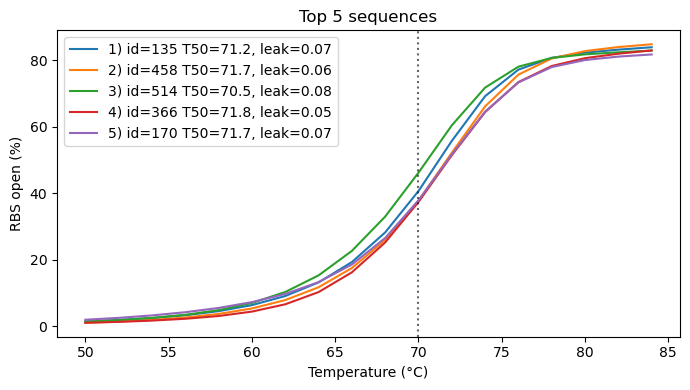

In [8]:
# ====== LIBRARY ANALYSIS ======
import csv
import numpy as np
import matplotlib.pyplot as plt

IN_CSV = "results/library_combined.csv"

# acceptance criteria (tweak to match our target)
SPEC = dict(
    min_closed_low = 0.90,   # ≤10% leak below ~68 °C
    min_open_midhi = 0.60,   # ≥60% ON in 72–78 °C
    min_open_high  = 0.80,   # ≥80% ON ≥80 °C
    t50_low        = 69.0,   # T50 window
    t50_high       = 72.5,
    min_slope70    = 0.04
)

def load_rows(path):
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        rows = []
        for d in r:
            # cast types
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len"]:
                d[k] = int(d[k]) if d[k] != "" else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","slope_max","reentrant_pen","score"]:
                d[k] = float(d[k]) if d[k] != "" else np.nan
            rows.append(d)
        return rows

def meets_spec(d):
    return (d["closed_low"] >= SPEC["min_closed_low"] and
            d["open_midhi"] >= SPEC["min_open_midhi"] and
            d["open_high"]  >= SPEC["min_open_high"]  and
            (SPEC["t50_low"] <= d["T50"] <= SPEC["t50_high"]) and
            d["slope70"]    >= SPEC["min_slope70"])

def rank_key(d):
    # best = steep near 70, T50 closest to 70, strong midhi, tight OFF
    return (-d["slope70"], abs(d["T50"]-70.0), -d["open_midhi"], -d["closed_low"])

def plot_top(rows, k=5):
    t = np.array(ALL_TS, float)
    plt.figure(figsize=(7.0, 4.0))
    for i, d in enumerate(rows[:k], 1):
        y = np.array([float(v) for v in d["curve"].split(";")])
        plt.plot(t, y*100, label=f"{i}) id={d['id']} T50={d['T50']:.1f}, leak={1-d['closed_low']:.2f}")
    plt.axvline(70, ls=":", color="k", alpha=0.6)
    plt.xlabel("Temperature (°C)"); plt.ylabel("RBS open (%)")
    plt.title(f"Top {min(k, len(rows))} sequences"); plt.legend(); plt.tight_layout(); plt.show()

rows = load_rows(IN_CSV)
hits = [d for d in rows if meets_spec(d)]
hits.sort(key=rank_key)

print(f"Total designs: {len(rows)}  |  Meets spec: {len(hits)}")
if hits:
    best = hits[0]
    print("Top pick:",
          f"id={best['id']}, len={best['len']}, T50={best['T50']:.2f}°C,",
          f"leak={1-best['closed_low']:.02f}, midhi={best['open_midhi']:.2f},",
          f"high={best['open_high']:.2f}, slope70={best['slope70']:.3f}")
    plot_top(hits, k=5)
else:
    print("No sequences met the spec — widen the window slightly and re-run.")


In [11]:
# ==========================================================
# Thermoswitch ML screen (with 5-fold CV)
# - Features: len, GC, extra_pairs, pGC, loop_len, dinucleotide freqs
# - Classifier: imbalance-aware + tuned threshold (recall or F1)
# - Regressors: T50 (GBR), slope70 (RF)
# - Outputs: results/ml_predictions.csv, results/ml_topK_summary.csv
# ==========================================================

import os, csv, math, warnings
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    precision_recall_curve, mean_absolute_error, r2_score
)

# ------------------ config ------------------
CSV_PATH = "results/library_combined.csv"   
OUT_DIR  = "results"
TOP_K    = 50
RANDOM_STATE = 42

# choose threshold policy
THRESHOLD_MODE = "recall"      # 'recall' or 'f1'
TARGET_RECALL  = 0.60          # used when THRESHOLD_MODE == 'recall'

# run 5-fold stratified CV summary?
RUN_CV = True

# pass/fail design spec (based on our project)
SPEC = dict(
    min_closed_low = 0.90,
    min_open_midhi = 0.60,
    min_open_high  = 0.80,
    t50_low        = 69.0,
    t50_high       = 72.5,
    min_slope70    = 0.04
)

# ------------------ IO helpers ------------------
def load_rows(path):
    rows = []
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        for d in r:
            # ints
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len","id"]:
                if k in d and d[k] != "":
                    try: d[k] = int(d[k])
                    except: d[k] = None
                else:
                    d[k] = d.get(k, None)
            # floats
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","score"]:
                if k in d and d[k] != "":
                    try: d[k] = float(d[k])
                    except: d[k] = float("nan")
                else:
                    d[k] = float("nan")
            rows.append(d)
    return rows

def meets_spec(d):
    # uses measured metrics in the CSV
    return (d["closed_low"]>=SPEC["min_closed_low"] and
            d["open_midhi"]>=SPEC["min_open_midhi"] and
            d["open_high"] >=SPEC["min_open_high"]  and
            SPEC["t50_low"]<=d["T50"]<=SPEC["t50_high"] and
            d["slope70"]   >=SPEC["min_slope70"])

# ------------------ feature builder ------------------
ALPH = "AUGC"
DINUCS = [a+b for a in ALPH for b in ALPH]  # 16

def dinuc_freqs(seq):
    if len(seq) < 2:
        return np.zeros(len(DINUCS), float)
    cnt = Counter(seq[i:i+2] for i in range(len(seq)-1))
    total = len(seq)-1
    return np.array([cnt.get(m,0)/total for m in DINUCS], float)

def make_features(row):
    seq = row["seq"]
    L   = len(seq)
    gc  = (seq.count("G")+seq.count("C"))/L if L else 0.0
    ep  = row.get("extra_pairs") or 0
    pGC = row.get("pGC", 0.0)
    pGC = 0.0 if (pGC is None or (isinstance(pGC, float) and math.isnan(pGC))) else pGC
    lp  = row.get("loop_len") or 0
    return np.array([L, gc, ep, pGC, lp, *dinuc_freqs(seq)], float)

# ------------------ load & prepare ------------------
rows_all = load_rows(CSV_PATH)
rows = [d for d in rows_all if ("seq" in d) and not math.isnan(d["T50"]) and not math.isnan(d["slope70"])]
if not rows:
    raise RuntimeError("No valid rows with T50 and slope70 found in CSV.")

X = np.vstack([make_features(d) for d in rows])
y_cls = np.array([int(meets_spec(d)) for d in rows], int)
y_t50 = np.array([d["T50"] for d in rows], float)
y_slp = np.array([d["slope70"] for d in rows], float)

pos_rate = y_cls.mean()
print(f"Loaded {len(rows)} designs | positives = {y_cls.sum()} ({pos_rate*100:.1f}%)")

# ------------------ train/test split ------------------
Xtr, Xte, ytr, yte, t50_tr, t50_te, slp_tr, slp_te, rows_tr, rows_te = train_test_split(
    X, y_cls, y_t50, y_slp, rows, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)

# ------------------ classifier (weighted + tuned threshold) ------------------
w_tr = compute_sample_weight(class_weight="balanced", y=ytr)
clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))

# Try to pass sample_weight through the pipeline (prefixed kwarg); fall back if not supported
try:
    clf.fit(Xtr, ytr, gradientboostingclassifier__sample_weight=w_tr)
except TypeError:
    warnings.warn("Could not pass sample_weight through pipeline; fitting without weights.")
    clf.fit(Xtr, ytr)

# choose threshold on TRAIN (IMPORTANT: align thresholds to prec/rec lengths)
p_tr = clf.predict_proba(Xtr)[:,1]
prec, rec, thr = precision_recall_curve(ytr, p_tr)   # len(thr) = len(rec) - 1

if THRESHOLD_MODE.lower() == "recall":
    idx = np.where(rec[:-1] >= TARGET_RECALL)[0]
    if idx.size:
        # use the LARGEST threshold that still reaches the target recall
        best_thr = float(thr[idx[-1]])
    else:
        # fallback if target recall never reached
        best_thr = float(np.median(thr)) if thr.size else 0.5
else:  # 'f1'
    f1 = 2*prec*rec/(prec+rec+1e-9)
    best_thr = float(thr[np.argmax(f1[:-1])]) if thr.size else 0.5
print(f"Chosen decision threshold ({THRESHOLD_MODE}): {best_thr:.3f}")

# evaluate on TEST
p_te   = clf.predict_proba(Xte)[:,1]
y_pred = (p_te >= best_thr).astype(int)
print(f"\nClassifier  | ROC-AUC={roc_auc_score(yte, p_te):.3f}  PR-AUC={average_precision_score(yte, p_te):.3f}")
print(classification_report(yte, y_pred, digits=3))

# ------------------ regressors ------------------
# T50: slightly stronger GBR setup
reg_t50 = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=3, subsample=0.8, random_state=0
    )
)
reg_t50.fit(Xtr, t50_tr)
t50_hat = reg_t50.predict(Xte)
print(f"T50   reg   | MAE={mean_absolute_error(t50_te, t50_hat):.3f}  R2={r2_score(t50_te, t50_hat):.3f}")

# slope70: RF works well
reg_slp = make_pipeline(StandardScaler(),
                        RandomForestRegressor(n_estimators=400, random_state=1, n_jobs=-1))
reg_slp.fit(Xtr, slp_tr)
slp_hat = reg_slp.predict(Xte)
print(f"slope reg   | MAE={mean_absolute_error(slp_te, slp_hat):.3f}  R2={r2_score(slp_te, slp_hat):.3f}")

# ------------------ 5-fold stratified CV summary ------------------
def stratified_cv_summary(X, y_cls, y_t50, y_slp, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    aucs, pr_aucs, recs = [], [], []
    mae_t50s, r2_t50s, mae_slps, r2_slps = [], [], [], []

    for tr, va in skf.split(X, y_cls):
        Xtr, Xva = X[tr], X[va]
        ytr, yva = y_cls[tr], y_cls[va]
        t50_tr, t50_va = y_t50[tr], y_t50[va]
        slp_tr, slp_va = y_slp[tr], y_slp[va]

        # classifier
        w_tr = compute_sample_weight(class_weight="balanced", y=ytr)
        clf = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
        try:
            clf.fit(Xtr, ytr, gradientboostingclassifier__sample_weight=w_tr)
        except TypeError:
            clf.fit(Xtr, ytr)

        # pick threshold on TRAIN by recall target (align lengths)
        p_tr = clf.predict_proba(Xtr)[:, 1]
        prec, rec, thr = precision_recall_curve(ytr, p_tr)
        idx = np.where(rec[:-1] >= TARGET_RECALL)[0]
        thr_use = float(thr[idx[-1]]) if idx.size else (float(np.median(thr)) if thr.size else 0.5)

        p_va = clf.predict_proba(Xva)[:,1]
        yhat = (p_va >= thr_use).astype(int)

        # metrics
        aucs.append(roc_auc_score(yva, p_va))
        pr_aucs.append(average_precision_score(yva, p_va))
        tp = ((yhat==1) & (yva==1)).sum()
        fn = ((yhat==0) & (yva==1)).sum()
        recs.append(tp / (tp+fn+1e-9))

        # regressors
        reg_t50 = make_pipeline(StandardScaler(),
                                GradientBoostingRegressor(n_estimators=600, learning_rate=0.05,
                                                          max_depth=3, subsample=0.8, random_state=0))
        reg_t50.fit(Xtr, t50_tr)
        pred_t50 = reg_t50.predict(Xva)
        mae_t50s.append(mean_absolute_error(t50_va, pred_t50))
        r2_t50s.append(r2_score(t50_va, pred_t50))

        reg_slp = make_pipeline(StandardScaler(),
                                RandomForestRegressor(n_estimators=400, random_state=1, n_jobs=-1))
        reg_slp.fit(Xtr, slp_tr)
        pred_slp = reg_slp.predict(Xva)
        mae_slps.append(mean_absolute_error(slp_va, pred_slp))
        r2_slps.append(r2_score(slp_va, pred_slp))

    def msd(a): return np.nanmean(a), np.nanstd(a)
    auc_m, auc_s = msd(aucs)
    pr_m,  pr_s  = msd(pr_aucs)
    rec_m, rec_s = msd(recs)
    t50_mae_m, t50_mae_s = msd(mae_t50s)
    t50_r2_m,  t50_r2_s  = msd(r2_t50s)
    slp_mae_m, slp_mae_s = msd(mae_slps)
    slp_r2_m,  slp_r2_s  = msd(r2_slps)

    print("\n5-fold CV summary (mean ± sd)")
    print(f"Classifier  | ROC-AUC {auc_m:.3f} ± {auc_s:.3f} | PR-AUC {pr_m:.3f} ± {pr_s:.3f} | Recall {rec_m:.3f} ± {rec_s:.3f}")
    print(f"T50   reg   | MAE     {t50_mae_m:.3f} ± {t50_mae_s:.3f} | R2 {t50_r2_m:.3f} ± {t50_r2_s:.3f}")
    print(f"slope reg   | MAE     {slp_mae_m:.3f} ± {slp_mae_s:.3f} | R2 {slp_r2_m:.3f} ± {slp_r2_s:.3f}")

if RUN_CV:
    stratified_cv_summary(X, y_cls, y_t50, y_slp, k=5)

# ------------------ score all rows, rank, and save (CSV only) ------------------
os.makedirs(OUT_DIR, exist_ok=True)

p_all   = clf.predict_proba(X)[:,1]
t50_all = reg_t50.predict(X)
slp_all = reg_slp.predict(X)

# keep confident passes using tuned threshold (recall-oriented); fallback if none
idx_keep = [i for i in range(len(rows)) if p_all[i] >= best_thr]
if not idx_keep:
    idx_keep = list(np.argsort(-p_all)[:TOP_K*2])

def rank_key(i):
    # prioritize: higher P(pass), T50 near 70, steeper slope, plus open_midhi if present
    open_midhi = rows[i].get("open_midhi", 0.0)
    return (p_all[i], -abs(t50_all[i]-70.0), slp_all[i], open_midhi)

top_idx = sorted(idx_keep, key=rank_key, reverse=True)[:TOP_K]

# 1) predictions for all rows
pred_csv = os.path.join(OUT_DIR, "ml_predictions.csv")
with open(pred_csv, "w", newline="") as fh:
    cols = ["id","seq","len","p_pass","t50_pred","slope70_pred",
            "closed_low","open_midhi","open_high","T50","slope70"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for i, d in enumerate(rows):
        w.writerow(dict(
            id=d.get("id", i),
            seq=d["seq"],
            len=len(d["seq"]),
            p_pass=float(p_all[i]),
            t50_pred=float(t50_all[i]),
            slope70_pred=float(slp_all[i]),
            closed_low=d.get("closed_low",""),
            open_midhi=d.get("open_midhi",""),
            open_high=d.get("open_high",""),
            T50=d.get("T50",""),
            slope70=d.get("slope70",""),
        ))

# 2) top-K summary only
top_csv = os.path.join(OUT_DIR, "ml_topK_summary.csv")
with open(top_csv, "w", newline="") as fh:
    cols = ["rank","id","seq","p_pass","t50_pred","slope70_pred"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for rank, i in enumerate(top_idx, 1):
        w.writerow(dict(rank=rank,
                        id=rows[i].get("id", i),
                        seq=rows[i]["seq"],
                        p_pass=float(p_all[i]),
                        t50_pred=float(t50_all[i]),
                        slope70_pred=float(slp_all[i])))

print(f"\nWrote {pred_csv} and {top_csv}")


Loaded 700 designs | positives = 112 (16.0%)
Chosen decision threshold (recall): 0.749

Classifier  | ROC-AUC=0.702  PR-AUC=0.304
              precision    recall  f1-score   support

           0      0.857     0.966     0.908       118
           1      0.429     0.136     0.207        22

    accuracy                          0.836       140
   macro avg      0.643     0.551     0.558       140
weighted avg      0.790     0.836     0.798       140

T50   reg   | MAE=1.559  R2=-0.091
slope reg   | MAE=0.007  R2=0.034

5-fold CV summary (mean ± sd)
Classifier  | ROC-AUC 0.589 ± 0.049 | PR-AUC 0.235 ± 0.054 | Recall 0.027 ± 0.036
T50   reg   | MAE     1.750 ± 0.064 | R2 -0.145 ± 0.053
slope reg   | MAE     0.007 ± 0.001 | R2 0.052 ± 0.047

Wrote results/ml_predictions.csv and results/ml_topK_summary.csv


In [12]:
# ==========================================================
# Thermoswitch ML — calibrated, recall-tilted ranking
# - Classifier: GBDT + isotonic calibration, class-weighted
# - Threshold: F_beta (β=2) by default (recall-tilted). Options: recall target, positive-quantile
# - Features: len, GC, extra_pairs, pGC, loop_len, 2-mer & 3-mer freqs, RBS-window positional one-hot
# - Metrics: ROC-AUC, PR-AUC, Precision@K / Recall@K (K=10,20,50), plus T50/slope regressors
# - CV: stratified 5-fold mean±sd for the same metrics
# - Outputs: results/ml_predictions.csv, results/ml_topK_summary.csv
# ==========================================================

import os, csv, math, warnings
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    precision_recall_curve, mean_absolute_error, r2_score
)

# ------------------ config ------------------
CSV_PATH = "results/library_combined.csv"   # <-- set this to your merged CSV
OUT_DIR  = "results"
TOP_KS   = [10, 20, 50]
TOP_K_SAVE = 50
RANDOM_STATE = 42

# threshold policy: 'f_beta', 'recall', or 'pos_quantile'
THRESHOLD_MODE = "f_beta"     # default: F_beta with beta=2
BETA = 2.0
TARGET_RECALL = 0.60          # used for 'recall' or 'pos_quantile'

# run 5-fold stratified CV summary?
RUN_CV = True

# pass/fail spec (labels built from measured columns in CSV)
SPEC = dict(
    min_closed_low = 0.90,
    min_open_midhi = 0.60,
    min_open_high  = 0.80,
    t50_low        = 69.0,
    t50_high       = 72.5,
    min_slope70    = 0.04
)

# ------------------ helpers ------------------
def load_rows(path):
    rows = []
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        for d in r:
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len","id"]:
                d[k] = int(d[k]) if d.get(k,"") not in (None,"") else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","score"]:
                d[k] = float(d[k]) if d.get(k,"") not in (None,"") else float("nan")
            rows.append(d)
    return rows

def meets_spec(d):
    return (d["closed_low"]>=SPEC["min_closed_low"] and
            d["open_midhi"]>=SPEC["min_open_midhi"] and
            d["open_high"] >=SPEC["min_open_high"]  and
            SPEC["t50_low"]<=d["T50"]<=SPEC["t50_high"] and
            d["slope70"]   >=SPEC["min_slope70"])

ALPH = "AUGC"
NUC_IDX = {b:i for i,b in enumerate(ALPH)}
DINUCS = [a+b for a in ALPH for b in ALPH]
TRIN  = [a+b+c for a in ALPH for b in ALPH for c in ALPH]

def dinuc_freqs(seq):
    if len(seq) < 2: return np.zeros(len(DINUCS), float)
    cnt = Counter(seq[i:i+2] for i in range(len(seq)-1))
    total = len(seq)-1
    return np.array([cnt.get(m,0)/total for m in DINUCS], float)

def trinuc_freqs(seq):
    if len(seq) < 3: return np.zeros(len(TRIN), float)
    cnt = Counter(seq[i:i+3] for i in range(len(seq)-2))
    total = len(seq)-2
    return np.array([cnt.get(m,0)/total for m in TRIN], float)

def rbs_window_onehot(seq, rbs_start, rbs_end, left=10, right=20):
    """
    Fixed-length one-hot over window [rbs_start-left, rbs_end+right)
    If indices fall outside the sequence, fill with zeros.
    Output shape: (window_len * 4,)
    """
    if rbs_start is None or rbs_end is None or rbs_start < 0 or rbs_end is None:
        # fall back if missing coordinates
        return np.zeros((left + (rbs_end or 0) - (rbs_start or 0) + right)*4, float) if rbs_start and rbs_end else np.zeros((left+6+right)*4, float)

    start = rbs_start - left
    stop  = rbs_end + right
    window_len = stop - start
    vec = np.zeros((window_len, 4), float)

    for i in range(window_len):
        j = start + i
        if 0 <= j < len(seq):
            b = seq[j]
            k = NUC_IDX.get(b)
            if k is not None:
                vec[i, k] = 1.0
    return vec.reshape(-1)

def make_features(row):
    seq = row["seq"]
    L   = len(seq)
    gc  = (seq.count("G")+seq.count("C"))/L if L else 0.0
    ep  = row.get("extra_pairs") or 0
    pGC = row.get("pGC", 0.0)
    if pGC is None or (isinstance(pGC, float) and math.isnan(pGC)): pGC = 0.0
    lp  = row.get("loop_len") or 0
    base = np.array([L, gc, ep, pGC, lp], float)
    k2   = dinuc_freqs(seq)
    k3   = trinuc_freqs(seq)
    # RBS positional window (±10, +20)
    rbs_vec = rbs_window_onehot(seq, row.get("rbs_start"), row.get("rbs_end"), left=10, right=20)
    return np.concatenate([base, k2, k3, rbs_vec])

def choose_threshold(p_tr, ytr, mode="f_beta", beta=2.0, target_recall=0.60):
    """Return a scalar probability threshold from the TRAIN PR curve."""
    prec, rec, thr = precision_recall_curve(ytr, p_tr)  # len(thr) = len(rec)-1
    if mode == "recall":
        idx = np.where(rec[:-1] >= target_recall)[0]
        return float(thr[idx[-1]]) if idx.size else (float(np.median(thr)) if thr.size else 0.5)
    elif mode == "f_beta":
        fbeta = (1+beta**2) * (prec*rec) / (beta**2*prec + rec + 1e-9)
        return float(thr[np.argmax(fbeta[:-1])]) if thr.size else 0.5
    elif mode == "pos_quantile":
        pos_scores = p_tr[ytr == 1]
        if pos_scores.size == 0: return 0.5
        q = max(0.0, min(1.0, 1.0 - target_recall))   # ensure ≥ target recall on TRAIN
        return float(np.quantile(pos_scores, q))
    else:
        return 0.5

def prec_rec_at_k(y_true, scores, K):
    K = min(K, len(scores))
    if K <= 0: return 0.0, 0.0
    idx = np.argsort(-scores)[:K]
    tp  = (y_true[idx] == 1).sum()
    P   = (y_true == 1).sum()
    prec = tp / K
    rec  = tp / (P + 1e-9)
    return float(prec), float(rec)

# ------------------ load & featurize ------------------
rows_all = load_rows(CSV_PATH)
rows = [d for d in rows_all if ("seq" in d) and not math.isnan(d["T50"]) and not math.isnan(d["slope70"])]
if not rows:
    raise RuntimeError("No valid rows with T50 and slope70 found in CSV.")

X = np.vstack([make_features(d) for d in rows])
y = np.array([int(meets_spec(d)) for d in rows], int)
y_t50 = np.array([d["T50"] for d in rows], float)
y_slp = np.array([d["slope70"] for d in rows], float)

print(f"Loaded {len(rows)} designs | positives = {y.sum()} ({100*y.mean():.1f}%)")

# ------------------ split ------------------
Xtr, Xte, ytr, yte, t50_tr, t50_te, slp_tr, slp_te, rows_tr, rows_te = train_test_split(
    X, y, y_t50, y_slp, rows, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# ------------------ classifier (GBDT + isotonic calibration) ------------------
base = GradientBoostingClassifier(random_state=0)
clf  = make_pipeline(StandardScaler(), CalibratedClassifierCV(base, method="isotonic", cv=3))

w_tr = compute_sample_weight(class_weight="balanced", y=ytr)
try:
    clf.fit(Xtr, ytr, calibratedclassifiercv__sample_weight=w_tr)
except TypeError:
    warnings.warn("sample_weight not accepted by calibrator in this sklearn; fitting without it.")
    clf.fit(Xtr, ytr)

p_tr = clf.predict_proba(Xtr)[:,1]
best_thr = choose_threshold(p_tr, ytr, mode=THRESHOLD_MODE, beta=BETA, target_recall=TARGET_RECALL)
print(f"Chosen decision threshold ({THRESHOLD_MODE}): {best_thr:.3f}")

p_te   = clf.predict_proba(Xte)[:,1]
y_pred = (p_te >= best_thr).astype(int)
print(f"\nClassifier  | ROC-AUC={roc_auc_score(yte, p_te):.3f}  PR-AUC={average_precision_score(yte, p_te):.3f}")
print(classification_report(yte, y_pred, digits=3))

for K in TOP_KS:
    pk, rk = prec_rec_at_k(yte, p_te, K)
    print(f"@K={K:>2}       | Precision={pk:.3f}  Recall={rk:.3f}")

# ------------------ regressors (for ranking) ------------------
reg_t50 = make_pipeline(StandardScaler(),
                        GradientBoostingRegressor(n_estimators=600, learning_rate=0.05,
                                                  max_depth=3, subsample=0.8, random_state=0))
reg_t50.fit(Xtr, t50_tr)
t50_hat = reg_t50.predict(Xte)
print(f"\nT50   reg   | MAE={mean_absolute_error(t50_te, t50_hat):.3f}  R2={r2_score(t50_te, t50_hat):.3f}")

reg_slp = make_pipeline(StandardScaler(),
                        RandomForestRegressor(n_estimators=400, random_state=1, n_jobs=-1))
reg_slp.fit(Xtr, slp_tr)
slp_hat = reg_slp.predict(Xte)
print(f"slope reg   | MAE={mean_absolute_error(slp_te, slp_hat):.3f}  R2={r2_score(slp_te, slp_hat):.3f}")

# ------------------ 5-fold stratified CV summary ------------------
def cv_summary(X, y, y_t50, y_slp, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    aucs, pr_aucs = [], []
    prec_at, rec_at = {K: [] for K in TOP_KS}, {K: [] for K in TOP_KS}
    t50_mae, t50_r2, slp_mae, slp_r2 = [], [], [], []

    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]
        ytr, yva = y[tr], y[va]
        t50_tr, t50_va = y_t50[tr], y_t50[va]
        slp_tr, slp_va = y_slp[tr], y_slp[va]

        base = GradientBoostingClassifier(random_state=0)
        clf  = make_pipeline(StandardScaler(), CalibratedClassifierCV(base, method="isotonic", cv=3))
        w = compute_sample_weight(class_weight="balanced", y=ytr)
        try:
            clf.fit(Xtr, ytr, calibratedclassifiercv__sample_weight=w)
        except TypeError:
            clf.fit(Xtr, ytr)

        p_tr = clf.predict_proba(Xtr)[:,1]
        thr  = choose_threshold(p_tr, ytr, mode=THRESHOLD_MODE, beta=BETA, target_recall=TARGET_RECALL)
        p_va = clf.predict_proba(Xva)[:,1]
        aucs.append(roc_auc_score(yva, p_va))
        pr_aucs.append(average_precision_score(yva, p_va))

        # Precision@K, Recall@K on validation
        for K in TOP_KS:
            pk, rk = prec_rec_at_k(yva, p_va, K)
            prec_at[K].append(pk)
            rec_at[K].append(rk)

        # regressors
        reg_t50 = make_pipeline(StandardScaler(),
                                GradientBoostingRegressor(n_estimators=600, learning_rate=0.05,
                                                          max_depth=3, subsample=0.8, random_state=0))
        reg_t50.fit(Xtr, t50_tr)
        t50_pred = reg_t50.predict(Xva)
        t50_mae.append(mean_absolute_error(t50_va, t50_pred))
        t50_r2.append(r2_score(t50_va, t50_pred))

        reg_slp = make_pipeline(StandardScaler(),
                                RandomForestRegressor(n_estimators=400, random_state=1, n_jobs=-1))
        reg_slp.fit(Xtr, slp_tr)
        slp_pred = reg_slp.predict(Xva)
        slp_mae.append(mean_absolute_error(slp_va, slp_pred))
        slp_r2.append(r2_score(slp_va, slp_pred))

    def msd(a): return np.nanmean(a), np.nanstd(a)

    print("\n5-fold CV summary (mean ± sd)")
    auc_m, auc_s = msd(aucs); pr_m, pr_s = msd(pr_aucs)
    print(f"Classifier  | ROC-AUC {auc_m:.3f} ± {auc_s:.3f} | PR-AUC {pr_m:.3f} ± {pr_s:.3f}")
    for K in TOP_KS:
        pm, ps = msd(prec_at[K]); rm, rs = msd(rec_at[K])
        print(f"@K={K:>2}       | Precision {pm:.3f} ± {ps:.3f} | Recall {rm:.3f} ± {rs:.3f}")
    t50_mae_m, t50_mae_s = msd(t50_mae); t50_r2_m, t50_r2_s = msd(t50_r2)
    slp_mae_m, slp_mae_s = msd(slp_mae); slp_r2_m, slp_r2_s = msd(slp_r2)
    print(f"T50   reg   | MAE {t50_mae_m:.3f} ± {t50_mae_s:.3f} | R2 {t50_r2_m:.3f} ± {t50_r2_s:.3f}")
    print(f"slope reg   | MAE {slp_mae_m:.3f} ± {slp_mae_s:.3f} | R2 {slp_r2_m:.3f} ± {slp_r2_s:.3f}")

if RUN_CV:
    cv_summary(X, y, y_t50, y_slp, k=5)

# ------------------ score all rows, rank, and save ------------------
os.makedirs(OUT_DIR, exist_ok=True)

# Use the trained (train-split) models to score all rows
p_all   = clf.predict_proba(X)[:,1]
t50_all = reg_t50.predict(X)
slp_all = reg_slp.predict(X)

# Keep confident passes at the tuned threshold; fallback to top by prob
idx_keep = [i for i in range(len(rows)) if p_all[i] >= best_thr] or list(np.argsort(-p_all)[:TOP_K_SAVE*2])

def rank_key(i):
    open_midhi = rows[i].get("open_midhi", 0.0)
    return (p_all[i], -abs(t50_all[i]-70.0), slp_all[i], open_midhi)

top_idx = sorted(idx_keep, key=rank_key, reverse=True)[:TOP_K_SAVE]

# 1) predictions for all rows
pred_csv = os.path.join(OUT_DIR, "ml_predictions.csv")
with open(pred_csv, "w", newline="") as fh:
    cols = ["id","seq","len","p_pass","t50_pred","slope70_pred",
            "closed_low","open_midhi","open_high","T50","slope70"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for i, d in enumerate(rows):
        w.writerow(dict(
            id=d.get("id", i),
            seq=d["seq"],
            len=len(d["seq"]),
            p_pass=float(p_all[i]),
            t50_pred=float(t50_all[i]),
            slope70_pred=float(slp_all[i]),
            closed_low=d.get("closed_low",""),
            open_midhi=d.get("open_midhi",""),
            open_high=d.get("open_high",""),
            T50=d.get("T50",""),
            slope70=d.get("slope70",""),
        ))

# 2) top-K summary only
top_csv = os.path.join(OUT_DIR, "ml_topK_summary.csv")
with open(top_csv, "w", newline="") as fh:
    cols = ["rank","id","seq","p_pass","t50_pred","slope70_pred"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for rank, i in enumerate(top_idx, 1):
        w.writerow(dict(rank=rank,
                        id=rows[i].get("id", i),
                        seq=rows[i]["seq"],
                        p_pass=float(p_all[i]),
                        t50_pred=float(t50_all[i]),
                        slope70_pred=float(slp_all[i])))

print(f"\nWrote {pred_csv} and {top_csv}")


Loaded 700 designs | positives = 112 (16.0%)
Chosen decision threshold (f_beta): 0.599

Classifier  | ROC-AUC=0.737  PR-AUC=0.390
              precision    recall  f1-score   support

           0      0.903     0.864     0.883       118
           1      0.407     0.500     0.449        22

    accuracy                          0.807       140
   macro avg      0.655     0.682     0.666       140
weighted avg      0.825     0.807     0.815       140

@K=10       | Precision=0.400  Recall=0.182
@K=20       | Precision=0.450  Recall=0.409
@K=50       | Precision=0.280  Recall=0.636

T50   reg   | MAE=1.168  R2=0.353
slope reg   | MAE=0.006  R2=0.347

5-fold CV summary (mean ± sd)
Classifier  | ROC-AUC 0.625 ± 0.060 | PR-AUC 0.285 ± 0.074
@K=10       | Precision 0.320 ± 0.147 | Recall 0.143 ± 0.067
@K=20       | Precision 0.300 ± 0.100 | Recall 0.269 ± 0.091
@K=50       | Precision 0.240 ± 0.042 | Recall 0.536 ± 0.097
T50   reg   | MAE 1.278 ± 0.123 | R2 0.354 ± 0.094
slope reg   | MAE 

In [13]:
# ==========================================================
# Thermoswitch ML — calibrated, recall-tilted ranking
# - Classifier: GradientBoosting + isotonic calibration (class-weighted)
# - Threshold: F_beta (β=2) by default; or 'recall' / 'pos_quantile'
# - Features: len, GC, extra_pairs, pGC, loop_len, 2-mer & 3-mer freqs,
#             RBS-window positional one-hot (fixed length)
# - Metrics: ROC-AUC, PR-AUC, Precision@K / Recall@K (K=10,20,50),
#            plus T50/slope regressors for ranking
# - CV: stratified 5-fold mean±sd for the same metrics
# - Outputs: results/ml_predictions.csv, results/ml_topK_summary.csv
# ==========================================================

import os, csv, math, warnings
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    precision_recall_curve,
    mean_absolute_error,
    r2_score,
)

# ------------------ config ------------------
CSV_PATH = "results/library_combined.csv"   # <-- set your combined CSV path
OUT_DIR  = "results"

TOP_KS       = [10, 20, 50]   # report @K metrics
TOP_K_SAVE   = 20             # how many designs to export in the ranked shortlist

RANDOM_STATE = 42

# threshold policy for pass/fail reporting: 'f_beta', 'recall', or 'pos_quantile'
THRESHOLD_MODE = "f_beta"
BETA           = 2.0          # used if THRESHOLD_MODE == 'f_beta'
TARGET_RECALL  = 0.70         # used for 'recall' and 'pos_quantile'

RUN_CV = True                 # print 5-fold stratified CV summary

# Optional hard guards to prune shortlist BEFORE ranking
USE_GUARDS       = True
GUARD_T50_RANGE  = (69.0, 72.5)
GUARD_SLOPE_MIN  = 0.040

# Label spec (uses measured columns in the CSV)
SPEC = dict(
    min_closed_low = 0.90,
    min_open_midhi = 0.60,
    min_open_high  = 0.80,
    t50_low        = 69.0,
    t50_high       = 72.5,
    min_slope70    = 0.04
)

# ------------------ IO + labels ------------------
def load_rows(path):
    rows = []
    with open(path, newline="") as fh:
        r = csv.DictReader(fh)
        for d in r:
            for k in ["len","rbs_start","rbs_end","extra_pairs","loop_len","id"]:
                d[k] = int(d[k]) if d.get(k,"") not in (None,"") else None
            for k in ["pGC","closed_low","open_midhi","open_high","slope70","T50","score"]:
                d[k] = float(d[k]) if d.get(k,"") not in (None,"") else float("nan")
            rows.append(d)
    return rows

def meets_spec(d):
    return (d["closed_low"]>=SPEC["min_closed_low"] and
            d["open_midhi"]>=SPEC["min_open_midhi"] and
            d["open_high"] >=SPEC["min_open_high"]  and
            SPEC["t50_low"]<=d["T50"]<=SPEC["t50_high"] and
            d["slope70"]   >=SPEC["min_slope70"])

# ------------------ features ------------------
ALPH = "AUGC"
NUC_IDX = {b:i for i,b in enumerate(ALPH)}
DINUCS = [a+b for a in ALPH for b in ALPH]            # 16
TRIN   = [a+b+c for a in ALPH for b in ALPH for c in ALPH]  # 64
DEFAULT_RBS_LEN = 6  # AGGAGG

def dinuc_freqs(seq):
    if len(seq) < 2: return np.zeros(len(DINUCS), float)
    cnt = Counter(seq[i:i+2] for i in range(len(seq)-1))
    total = len(seq)-1
    return np.array([cnt.get(m,0)/total for m in DINUCS], float)

def trinuc_freqs(seq):
    if len(seq) < 3: return np.zeros(len(TRIN), float)
    cnt = Counter(seq[i:i+3] for i in range(len(seq)-2))
    total = len(seq)-2
    return np.array([cnt.get(m,0)/total for m in TRIN], float)

def rbs_window_onehot(seq, rbs_start, rbs_end, left=10, right=20, rbs_len_default=DEFAULT_RBS_LEN):
    """
    Fixed-length one-hot around the RBS: [start-left, end+right)
    If indices missing/invalid, return all-zeros of expected length.
    Output length = (left + rbs_len + right) * 4
    """
    if rbs_start is None or rbs_end is None or rbs_end <= rbs_start:
        window_len = left + rbs_len_default + right
        return np.zeros(window_len * 4, float)

    rbs_len = max(1, rbs_end - rbs_start)
    window_len = left + rbs_len + right
    start = rbs_start - left

    vec = np.zeros((window_len, 4), float)
    for i in range(window_len):
        j = start + i
        if 0 <= j < len(seq):
            k = NUC_IDX.get(seq[j])
            if k is not None: vec[i, k] = 1.0
    return vec.reshape(-1)

def make_features(row):
    seq = row["seq"]
    L   = len(seq)
    gc  = (seq.count("G")+seq.count("C"))/L if L else 0.0
    ep  = row.get("extra_pairs") or 0
    pGC = row.get("pGC", 0.0)
    if pGC is None or (isinstance(pGC, float) and math.isnan(pGC)): pGC = 0.0
    lp  = row.get("loop_len") or 0

    base = np.array([L, gc, ep, pGC, lp], float)
    k2   = dinuc_freqs(seq)
    k3   = trinuc_freqs(seq)
    rbsv = rbs_window_onehot(seq, row.get("rbs_start"), row.get("rbs_end"), left=10, right=20)

    return np.concatenate([base, k2, k3, rbsv])

# ------------------ thresholds & ranking ------------------
def choose_threshold(p_tr, ytr, mode="f_beta", beta=2.0, target_recall=0.70):
    """Return a probability threshold from the TRAIN PR curve."""
    prec, rec, thr = precision_recall_curve(ytr, p_tr)  # len(thr) = len(rec)-1
    if mode == "recall":
        idx = np.where(rec[:-1] >= target_recall)[0]
        return float(thr[idx[-1]]) if idx.size else (float(np.median(thr)) if thr.size else 0.5)
    elif mode == "f_beta":
        fbeta = (1+beta**2) * (prec*rec) / (beta**2*prec + rec + 1e-9)
        return float(thr[np.argmax(fbeta[:-1])]) if thr.size else 0.5
    elif mode == "pos_quantile":
        pos_scores = p_tr[ytr == 1]
        if pos_scores.size == 0: return 0.5
        q = max(0.0, min(1.0, 1.0 - target_recall))   # ensure ≥ target recall on TRAIN
        return float(np.quantile(pos_scores, q))
    else:
        return 0.5

def prec_rec_at_k(y_true, scores, K):
    K = min(K, len(scores))
    if K <= 0: return 0.0, 0.0
    idx = np.argsort(-scores)[:K]
    tp  = (y_true[idx] == 1).sum()
    P   = (y_true == 1).sum()
    prec = tp / K
    rec  = tp / (P + 1e-9)
    return float(prec), float(rec)

# ------------------ load & featurize ------------------
rows_all = load_rows(CSV_PATH)
rows = [d for d in rows_all if ("seq" in d) and not math.isnan(d["T50"]) and not math.isnan(d["slope70"])]
if not rows:
    raise RuntimeError("No valid rows with T50 and slope70 found in CSV.")

X = np.vstack([make_features(d) for d in rows])
y = np.array([int(meets_spec(d)) for d in rows], int)
y_t50 = np.array([d["T50"] for d in rows], float)
y_slp = np.array([d["slope70"] for d in rows], float)

print(f"Loaded {len(rows)} designs | positives = {y.sum()} ({100*y.mean():.1f}%)")

# ------------------ split ------------------
Xtr, Xte, ytr, yte, t50_tr, t50_te, slp_tr, slp_te, rows_tr, rows_te = train_test_split(
    X, y, y_t50, y_slp, rows, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# ------------------ classifier (GBDT + isotonic calibration) ------------------
base = GradientBoostingClassifier(random_state=0)
clf  = make_pipeline(StandardScaler(), CalibratedClassifierCV(base, method="isotonic", cv=3))

w_tr = compute_sample_weight(class_weight="balanced", y=ytr)
try:
    clf.fit(Xtr, ytr, calibratedclassifiercv__sample_weight=w_tr)
except TypeError:
    warnings.warn("sample_weight not accepted by calibrator; fitting without it.")
    clf.fit(Xtr, ytr)

p_tr = clf.predict_proba(Xtr)[:,1]
best_thr = choose_threshold(p_tr, ytr, mode=THRESHOLD_MODE, beta=BETA, target_recall=TARGET_RECALL)
print(f"Chosen decision threshold ({THRESHOLD_MODE}): {best_thr:.3f}")

p_te   = clf.predict_proba(Xte)[:,1]
y_pred = (p_te >= best_thr).astype(int)
print(f"\nClassifier  | ROC-AUC={roc_auc_score(yte, p_te):.3f}  PR-AUC={average_precision_score(yte, p_te):.3f}")
print(classification_report(yte, y_pred, digits=3))
for K in TOP_KS:
    pk, rk = prec_rec_at_k(yte, p_te, K)
    print(f"@K={K:>2}       | Precision={pk:.3f}  Recall={rk:.3f}")

# ------------------ regressors (for ranking) ------------------
reg_t50 = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(n_estimators=600, learning_rate=0.05,
                              max_depth=3, subsample=0.8, random_state=0)
)
reg_t50.fit(Xtr, t50_tr)
t50_hat = reg_t50.predict(Xte)
print(f"\nT50   reg   | MAE={mean_absolute_error(t50_te, t50_hat):.3f}  R2={r2_score(t50_te, t50_hat):.3f}")

reg_slp = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=400, random_state=1, n_jobs=-1)
)
reg_slp.fit(Xtr, slp_tr)
slp_hat = reg_slp.predict(Xte)
print(f"slope reg   | MAE={mean_absolute_error(slp_te, slp_hat):.3f}  R2={r2_score(slp_te, slp_hat):.3f}")

# ------------------ 5-fold stratified CV summary (optional) ------------------
def cv_summary(X, y, y_t50, y_slp, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    aucs, pr_aucs = [], []
    prec_at, rec_at = {K: [] for K in TOP_KS}, {K: [] for K in TOP_KS}
    t50_mae, t50_r2, slp_mae, slp_r2 = [], [], [], []

    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]
        ytr, yva = y[tr], y[va]
        t50_tr, t50_va = y_t50[tr], y_t50[va]
        slp_tr, slp_va = y_slp[tr], y_slp[va]

        base = GradientBoostingClassifier(random_state=0)
        clf  = make_pipeline(StandardScaler(), CalibratedClassifierCV(base, method="isotonic", cv=3))
        w = compute_sample_weight(class_weight="balanced", y=ytr)
        try:
            clf.fit(Xtr, ytr, calibratedclassifiercv__sample_weight=w)
        except TypeError:
            clf.fit(Xtr, ytr)

        p_tr = clf.predict_proba(Xtr)[:,1]
        thr  = choose_threshold(p_tr, ytr, mode=THRESHOLD_MODE, beta=BETA, target_recall=TARGET_RECALL)
        p_va = clf.predict_proba(Xva)[:,1]

        aucs.append(roc_auc_score(yva, p_va))
        pr_aucs.append(average_precision_score(yva, p_va))
        for K in TOP_KS:
            pk, rk = prec_rec_at_k(yva, p_va, K)
            prec_at[K].append(pk); rec_at[K].append(rk)

        reg_t50 = make_pipeline(StandardScaler(),
                                GradientBoostingRegressor(n_estimators=600, learning_rate=0.05,
                                                          max_depth=3, subsample=0.8, random_state=0))
        reg_t50.fit(Xtr, t50_tr)
        t50_pred = reg_t50.predict(Xva)
        t50_mae.append(mean_absolute_error(t50_va, t50_pred))
        t50_r2.append(r2_score(t50_va, t50_pred))

        reg_slp = make_pipeline(StandardScaler(),
                                RandomForestRegressor(n_estimators=400, random_state=1, n_jobs=-1))
        reg_slp.fit(Xtr, slp_tr)
        slp_pred = reg_slp.predict(Xva)
        slp_mae.append(mean_absolute_error(slp_va, slp_pred))
        slp_r2.append(r2_score(slp_va, slp_pred))

    def msd(a): return np.nanmean(a), np.nanstd(a)
    print("\n5-fold CV summary (mean ± sd)")
    auc_m, auc_s = msd(aucs); pr_m, pr_s = msd(pr_aucs)
    print(f"Classifier  | ROC-AUC {auc_m:.3f} ± {auc_s:.3f} | PR-AUC {pr_m:.3f} ± {pr_s:.3f}")
    for K in TOP_KS:
        pm, ps = msd(prec_at[K]); rm, rs = msd(rec_at[K])
        print(f"@K={K:>2}       | Precision {pm:.3f} ± {ps:.3f} | Recall {rm:.3f} ± {rs:.3f}")
    t50_mae_m, t50_mae_s = msd(t50_mae); t50_r2_m, t50_r2_s = msd(t50_r2)
    slp_mae_m, slp_mae_s = msd(slp_mae); slp_r2_m, slp_r2_s = msd(slp_r2)
    print(f"T50   reg   | MAE {t50_mae_m:.3f} ± {t50_mae_s:.3f} | R2 {t50_r2_m:.3f} ± {t50_r2_s:.3f}")
    print(f"slope reg   | MAE {slp_mae_m:.3f} ± {slp_mae_s:.3f} | R2 {slp_r2_m:.3f} ± {slp_r2_s:.3f}")

if RUN_CV:
    cv_summary(X, y, y_t50, y_slp, k=5)

# ------------------ score all rows, (optionally) guard, rank, and save --------
os.makedirs(OUT_DIR, exist_ok=True)

p_all   = clf.predict_proba(X)[:,1]
t50_all = reg_t50.predict(X)
slp_all = reg_slp.predict(X)

# Optional guard pool (predicted physics)
if USE_GUARDS:
    t_lo, t_hi = GUARD_T50_RANGE
    mask = (t50_all >= t_lo) & (t50_all <= t_hi) & (slp_all >= GUARD_SLOPE_MIN)
    idx_pool = np.where(mask)[0]
    if idx_pool.size == 0:
        warnings.warn("Guard mask empty; falling back to all candidates.")
        idx_pool = np.arange(len(rows))
else:
    idx_pool = np.arange(len(rows))

def rank_key(i):
    open_midhi = rows[i].get("open_midhi", 0.0)
    return (p_all[i], -abs(t50_all[i]-70.0), slp_all[i], open_midhi)

top_idx = sorted(idx_pool, key=rank_key, reverse=True)[:TOP_K_SAVE]

# 1) predictions for all rows
pred_csv = os.path.join(OUT_DIR, "ml_predictions.csv")
with open(pred_csv, "w", newline="") as fh:
    cols = ["id","seq","len","p_pass","t50_pred","slope70_pred",
            "closed_low","open_midhi","open_high","T50","slope70"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for i, d in enumerate(rows):
        w.writerow(dict(
            id=d.get("id", i),
            seq=d["seq"],
            len=len(d["seq"]),
            p_pass=float(p_all[i]),
            t50_pred=float(t50_all[i]),
            slope70_pred=float(slp_all[i]),
            closed_low=d.get("closed_low",""),
            open_midhi=d.get("open_midhi",""),
            open_high=d.get("open_high",""),
            T50=d.get("T50",""),
            slope70=d.get("slope70",""),
        ))

# 2) top-K shortlist
top_csv = os.path.join(OUT_DIR, "ml_topK_summary.csv")
with open(top_csv, "w", newline="") as fh:
    cols = ["rank","id","seq","p_pass","t50_pred","slope70_pred"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for rank, i in enumerate(top_idx, 1):
        w.writerow(dict(rank=rank,
                        id=rows[i].get("id", i),
                        seq=rows[i]["seq"],
                        p_pass=float(p_all[i]),
                        t50_pred=float(t50_all[i]),
                        slope70_pred=float(slp_all[i])))

print(f"\nWrote {pred_csv} and {top_csv}")


Loaded 700 designs | positives = 112 (16.0%)
Chosen decision threshold (f_beta): 0.599

Classifier  | ROC-AUC=0.737  PR-AUC=0.390
              precision    recall  f1-score   support

           0      0.903     0.864     0.883       118
           1      0.407     0.500     0.449        22

    accuracy                          0.807       140
   macro avg      0.655     0.682     0.666       140
weighted avg      0.825     0.807     0.815       140

@K=10       | Precision=0.400  Recall=0.182
@K=20       | Precision=0.450  Recall=0.409
@K=50       | Precision=0.280  Recall=0.636

T50   reg   | MAE=1.168  R2=0.353
slope reg   | MAE=0.006  R2=0.347

5-fold CV summary (mean ± sd)
Classifier  | ROC-AUC 0.625 ± 0.060 | PR-AUC 0.285 ± 0.074
@K=10       | Precision 0.320 ± 0.147 | Recall 0.143 ± 0.067
@K=20       | Precision 0.300 ± 0.100 | Recall 0.269 ± 0.091
@K=50       | Precision 0.240 ± 0.042 | Recall 0.536 ± 0.097
T50   reg   | MAE 1.278 ± 0.123 | R2 0.354 ± 0.094
slope reg   | MAE 

In [14]:
# --- diversify_topK.py (run after your main script) ---
import csv, os, itertools

IN = "results/ml_predictions.csv"       # from your main script
OUT = "results/ml_topK_diverse.csv"
K = 20                                  # same K you plan to test

def kmerset(seq, k=3):
    return set(seq[i:i+k] for i in range(len(seq)-k+1)) if len(seq)>=k else set()

def jaccard(a, b):
    if not a and not b: return 0.0
    inter = len(a & b); union = len(a | b)
    return inter/union

rows = []
with open(IN, newline="") as fh:
    for r in csv.DictReader(fh):
        r["p_pass"]     = float(r["p_pass"])
        r["t50_pred"]   = float(r["t50_pred"])
        r["slope70_pred"]= float(r["slope70_pred"])
        r["kmers"]      = kmerset(r["seq"], 3)
        rows.append(r)

# take a pool of the top 3K by probability, then diversify
pool = sorted(rows, key=lambda r: (r["p_pass"], -abs(r["t50_pred"]-70), r["slope70_pred"]), reverse=True)[:K*3]

selected = []
while pool and len(selected)<K:
    if not selected:
        selected.append(pool.pop(0))
        continue
    # pick the sequence that maximizes its minimum distance to current set
    def min_dist(r):
        return min(1.0 - jaccard(r["kmers"], s["kmers"]) for s in selected)
    best = max(pool, key=min_dist)
    pool.remove(best)
    selected.append(best)

# write
os.makedirs("results", exist_ok=True)
with open(OUT, "w", newline="") as fh:
    cols = ["rank","id","seq","p_pass","t50_pred","slope70_pred"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for i, r in enumerate(selected, 1):
        w.writerow(dict(rank=i, id=r["id"], seq=r["seq"],
                        p_pass=r["p_pass"], t50_pred=r["t50_pred"], slope70_pred=r["slope70_pred"]))
print(f"Wrote {OUT}")


Wrote results/ml_topK_diverse.csv


In [15]:
# --- qc_check.py ---
import csv, re

IN = "results/ml_topK_diverse.csv"

def gc_frac(seq): return (seq.count("G")+seq.count("C"))/len(seq)
def homopolymers(seq, n=7): return re.findall(r"(A{%d,}|U{%d,}|G{%d,}|C{%d,})" % (n,n,n,n), seq)

with open(IN, newline="") as fh:
    for r in csv.DictReader(fh):
        seq = r["seq"]
        issues = []
        g = gc_frac(seq)
        if g < 0.20 or g > 0.70: issues.append(f"GC={g:.2f}")
        runs = homopolymers(seq, 7)
        if runs: issues.append(f"homopolymer={runs[0][0]}")
        if issues:
            print(f"id={r['id']}  WARN:", "; ".join(issues))


id=570  WARN: homopolymer=A
id=34  WARN: homopolymer=U


In [16]:
# refine_shortlist.py — clean & refill the diversified shortlist
import csv, os, re

PRED = "results/ml_predictions.csv"       # all predictions (from main script)
IN   = "results/ml_topK_diverse.csv"      # your diversified shortlist
OUT  = "results/ml_topK_diverse_clean.csv"

K = 20   # set to your lab capacity (should match what you used to build the shortlist)

# QC thresholds
GC_MIN, GC_MAX     = 0.25, 0.70
HOMO_N             = 7
USE_GUARDS         = True
GUARD_T50_RANGE    = (69.0, 72.5)
GUARD_SLOPE_MIN    = 0.040

def gc_frac(seq): 
    L = len(seq)
    return 0.0 if L == 0 else (seq.count("G")+seq.count("C"))/L

def fails_homopolymer(seq, n=HOMO_N):
    return re.search(rf"(A{{{n},}}|U{{{n},}}|G{{{n},}}|C{{{n},}})", seq) is not None

def kmerset(seq, k=3):
    return set(seq[i:i+k] for i in range(len(seq)-k+1)) if len(seq)>=k else set()

def rank_key(r):
    # same ranking as main script: probability, closeness to 70, slope, then open_midhi if present
    return (r["p_pass"], -abs(r["t50_pred"]-70.0), r["slope70_pred"], r.get("open_midhi", 0.0))

def read_predictions(path):
    rows = []
    with open(path, newline="") as fh:
        for d in csv.DictReader(fh):
            d["p_pass"]       = float(d["p_pass"])
            d["t50_pred"]     = float(d["t50_pred"])
            d["slope70_pred"] = float(d["slope70_pred"])
            # optional real metrics if present (not used for ranking)
            for k in ("closed_low","open_midhi","open_high","T50","slope70"):
                if k in d and d[k]!="":
                    try: d[k] = float(d[k])
                    except: pass
            rows.append(d)
    return rows

def read_shortlist(path):
    rows = []
    with open(path, newline="") as fh:
        for d in csv.DictReader(fh):
            rows.append(d)
    return rows

def passes_qc(r):
    seq = r["seq"]
    g = gc_frac(seq)
    if g < GC_MIN or g > GC_MAX: 
        return False
    if fails_homopolymer(seq): 
        return False
    if USE_GUARDS:
        tlo, thi = GUARD_T50_RANGE
        if not (tlo <= r["t50_pred"] <= thi): 
            return False
        if r["slope70_pred"] < GUARD_SLOPE_MIN: 
            return False
    return True

# --- load data ---
preds = read_predictions(PRED)
preds_sorted = sorted(preds, key=rank_key, reverse=True)

short = read_shortlist(IN)
K = min(K, len(short))  # keep K consistent with your shortlist size

# map id -> full row from predictions
by_id = {str(r["id"]): r for r in preds}
sel_ids = [str(r["id"]) for r in short]   # original selected IDs (as strings)

# keep only those selected that still pass QC
selected = []
removed = []
for sid in sel_ids:
    rec = by_id.get(sid)
    if rec and passes_qc(rec):
        selected.append(rec)
    else:
        removed.append(sid)

# build candidate pool (top 5*K) that pass QC and aren't already selected
pool = []
seen = {str(r.get("id")) for r in selected}
for r in preds_sorted:
    sid = str(r.get("id"))
    if sid in seen: 
        continue
    if not passes_qc(r):
        continue
    pool.append(r)
    if len(pool) >= 5*K:
        break

# add k-mer sets for diversity
for r in selected:
    r["kmers"] = kmerset(r["seq"], 3)
for r in pool:
    r["kmers"] = kmerset(r["seq"], 3)

# greedy diversify: pick the sequence maximizing min distance to current set
def min_dist_to_set(r, S):
    if not S: 
        return 1.0
    rk = r["kmers"]
    best = 1.0
    for s in S:
        inter = len(rk & s["kmers"]); union = len(rk | s["kmers"])
        j = inter/union if union else 0.0   # jaccard
        d = 1.0 - j
        if d < best: best = d
    return best

added = []
while len(selected) < K and pool:
    best = max(pool, key=lambda r: (min_dist_to_set(r, selected),) + rank_key(r))
    pool.remove(best)
    selected.append(best)
    added.append(str(best.get("id")))

# write clean shortlist
os.makedirs("results", exist_ok=True)
with open(OUT, "w", newline="") as fh:
    cols = ["rank","id","seq","p_pass","t50_pred","slope70_pred"]
    w = csv.DictWriter(fh, fieldnames=cols); w.writeheader()
    for i, r in enumerate(selected, 1):
        w.writerow(dict(rank=i, id=r.get("id"), seq=r["seq"],
                        p_pass=r["p_pass"], t50_pred=r["t50_pred"], slope70_pred=r["slope70_pred"]))

print(f"Wrote {OUT}")
if removed:
    print("Replaced (failed QC):", ", ".join(removed))
if added:
    print("Added:", ", ".join(added))


Wrote results/ml_topK_diverse_clean.csv
Replaced (failed QC): 570, 317, 34
Added: 35, 119, 436


In [17]:
# make_order_sheet.py
import csv, os
IN  = "results/ml_topK_diverse_clean.csv"
OUT = "results/ml_order_sheet.csv"

def gc(seq): 
    return (seq.count("G")+seq.count("C"))/len(seq) if seq else 0.0

os.makedirs("results", exist_ok=True)
with open(IN, newline="") as fh, open(OUT, "w", newline="") as fo:
    r = csv.DictReader(fh)
    cols = ["rank","id","seq","len_nt","gc_frac","p_pass","t50_pred","slope70_pred"]
    w = csv.DictWriter(fo, fieldnames=cols); w.writeheader()
    for row in r:
        s = row["seq"]
        w.writerow(dict(
            rank=row["rank"],
            id=row["id"],
            seq=s,
            len_nt=len(s),
            gc_frac=f"{gc(s):.2f}",
            p_pass=row["p_pass"],
            t50_pred=row["t50_pred"],
            slope70_pred=row["slope70_pred"],
        ))
print(f"Wrote {OUT}")


Wrote results/ml_order_sheet.csv


In [6]:
# ======================================================
# Figures with anti-overlap fixes
# F1..F6 + S1 (ROC) + S2 (CV bars) + S4 (diversity)
# ======================================================
import os, csv, math, re
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

# ---------- Paths ----------
PRED_CSV  = "results/ml_predictions.csv"
TOPK_CSV  = "results/ml_topK_diverse_clean.csv"
LIB_CSV   = "results/library_combined.csv"
os.makedirs("fig", exist_ok=True)

# ---------- Visual style ----------
_OKABE_ITO = ["#0072B2", "#E69F00", "#009E73", "#D55E00",
              "#CC79A7", "#56B4E9", "#F0E442", "#999999"]

def set_style():
    plt.rcParams.update({
        "font.size": 11,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 1.0,
        "lines.linewidth": 2.0,
        "grid.color": "#9e9e9e",
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "figure.autolayout": False,
        # Use Okabe–Ito as the global color cycle for line plots
        "axes.prop_cycle": cycler(color=_OKABE_ITO),
    })

def save_fig(path, rect=None):
    """rect can reserve margins when legend is outside: e.g., rect=[0,0,0.86,1]."""
    if rect is None:
        plt.tight_layout(pad=0.6)
    else:
        plt.tight_layout(pad=0.6, rect=rect)
    plt.savefig(path, dpi=300)
    plt.close()

# ---- Anti-overlap helpers for bar charts ----
def set_ylim_with_headroom(ax, heights, yerr=None, top_pad=0.06, cap=1.0):
    """Give bars breathing room so labels/errorbars never hit the ceiling."""
    h = np.asarray(heights, float)
    e = np.asarray(yerr, float) if yerr is not None else np.zeros_like(h)
    top = float(np.max(h + e))
    if cap is not None:
        ax.set_ylim(0, max(cap, top) + top_pad)
    else:
        ax.set_ylim(0, top + top_pad)

def add_bar_value_labels(ax, fmt="{:.2f}", yerr=None, frac_offset=0.015, smart_inside=True):
    """
    Place value labels just above each bar; if bar is near the axis ceiling,
    put the label INSIDE the bar with a small white box for readability.
    """
    yr = ax.get_ylim()[1] - ax.get_ylim()[0]
    errs = np.asarray(yerr, float) if yerr is not None else 0.0
    for i, p in enumerate(ax.patches):
        h = p.get_height()
        e = errs[i] if np.ndim(errs) else errs
        if smart_inside and (h + e) > (ax.get_ylim()[1] - 0.02*yr):
            y = h - 0.04*yr
            va = "top"
            color = "white"
            bbox = dict(boxstyle="round,pad=0.15", fc="#1f77b4", ec="none", alpha=0.85)
        else:
            y = h + e + frac_offset * yr
            va = "bottom"
            color = "black"
            bbox = None
        ax.text(p.get_x() + p.get_width()/2, y, fmt.format(h),
                ha="center", va=va, fontsize=9, color=color, bbox=bbox)

def mean_sd_lines(ax, x, color="#444", label="mean±SD"):
    mu, sd = float(np.mean(x)), float(np.std(x))
    ax.axvline(mu, color=color, lw=1.8, ls="-", label=f"{label} (μ={mu:.2f})")
    ax.axvspan(mu - sd, mu + sd, color=color, alpha=0.08)

# ---- New: distinct colors for ANY patches (bars/hist bins) ----
def apply_distinct_patch_colors(ax, edge="#1f2937", lw=0.9, alpha=0.95, palette=_OKABE_ITO):
    for i, p in enumerate(ax.patches):
        p.set_facecolor(palette[i % len(palette)])
        p.set_edgecolor(edge)
        p.set_linewidth(lw)
        p.set_alpha(alpha)

# ---------- Data helpers ----------
SPEC = dict(min_closed_low=0.90, min_open_midhi=0.60, min_open_high=0.80,
            t50_low=69.0, t50_high=72.5, min_slope70=0.04)

def meets_spec_row(d):
    try:
        cl = float(d.get("closed_low", "nan"))
        om = float(d.get("open_midhi", "nan"))
        oh = float(d.get("open_high", "nan"))
        t50 = float(d.get("T50", "nan"))
        sl = float(d.get("slope70", "nan"))
    except Exception:
        return False
    if any(map(math.isnan, [cl, om, oh, t50, sl])): return False
    return (cl>=SPEC["min_closed_low"] and om>=SPEC["min_open_midhi"] and
            oh>=SPEC["min_open_high"] and SPEC["t50_low"]<=t50<=SPEC["t50_high"] and
            sl>=SPEC["min_slope70"])

def read_rows(path):
    with open(path, newline="") as fh:
        return list(csv.DictReader(fh))

# ======================================================
# F1 — Optimized RBS openness curve (best design)
# ======================================================
def fig_F1(best_id=None, rbs="AGGAGG", temps=range(50, 86, 2)):
    try:
        import nupack as nu
    except Exception as e:
        print("[F1] Skipping (NUPACK not installed):", e)
        return

    top = read_rows(TOPK_CSV)
    if not top:
        print("[F1] No rows in TOPK; skipping.")
        return
    if best_id is None:
        best_id = top[0]["id"]

    lib = {str(r.get("id")): r for r in read_rows(LIB_CSV)}
    rec = lib.get(str(best_id))
    if not rec:
        print(f"[F1] id={best_id} not in library; skipping.")
        return

    seq = rec["seq"]

    def scan_rbs(s, motif=rbs):
        i = s.find(motif)
        return (i, i+len(motif)) if i>=0 else (None, None)

    try:
        rs = int(rec.get("rbs_start")) if rec.get("rbs_start") not in ("", None) else None
        re_ = int(rec.get("rbs_end"))  if rec.get("rbs_end")  not in ("", None) else None
    except Exception:
        rs, re_ = None, None
    if (rs is None) or (re_ is None) or (re_<=rs):
        rs, re_ = scan_rbs(seq)
        if rs is None:
            print("[F1] RBS not found; skipping.")
            return

    ION_NA, ION_MG = 1.0, 0.0
    def model_at(c): return nu.Model(material="rna", celsius=float(c), sodium=ION_NA, magnesium=ION_MG)
    def unpaired_probs(s, t):
        pm = nu.pairs(strands=[s], model=model_at(t))
        P  = pm.to_array()
        return np.diag(P)
    def rbs_open(s, t):
        u = unpaired_probs(s, t)
        sl = u[rs:re_]
        return float(np.mean(sl)) if sl.size else np.nan

    temps = list(temps)
    rbs_curve = np.array([rbs_open(seq, t) for t in temps])
    whole     = np.array([np.mean(unpaired_probs(seq, t)) for t in temps])

    # Estimate T50 by linear interpolation
    def interp_T50(T, y):
        T = np.array(T, float); y = np.array(y, float)
        idx = np.searchsorted(y, 0.5)
        if 0 < idx < len(y):
            return T[idx-1] + (0.5-y[idx-1])*(T[idx]-T[idx-1])/(y[idx]-y[idx-1])
        return np.nan
    T50_est = interp_T50(temps, rbs_curve)

    set_style()
    fig, ax = plt.subplots(figsize=(6.8, 4.1))
    ax.plot(temps, 100*rbs_curve, label="RBS open (%)")         # color[0]
    ax.plot(temps, 100*whole, ls="--", label="Whole-body unpaired (%)")  # color[1]
    # 70 °C reference
    ax.axvline(70, ls=":", color="#444", lw=1.2, zorder=1)
    yl = ax.get_ylim(); span_y = yl[1]-yl[0]
    ax.text(70.2, yl[0]+0.08*span_y, "70 °C",
            fontsize=10, color="#444",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))
    # T50 callout
    if not math.isnan(T50_est):
        ax.axvline(T50_est, ls="--", color=_OKABE_ITO[0], lw=1.5, alpha=0.9, zorder=2)
        xlim = ax.get_xlim()
        xtext, ha = T50_est + 1.2, "left"
        if xtext > xlim[1] - 0.5:
            xtext, ha = T50_est - 1.2, "right"
        ytext = yl[0] + 0.22*span_y
        ax.annotate(f"T50 ≈ {T50_est:.2f} °C",
                    xy=(T50_est, ytext), xytext=(xtext, ytext),
                    textcoords="data", ha=ha, va="center", fontsize=10, color=_OKABE_ITO[0],
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.85),
                    arrowprops=dict(arrowstyle="-", color=_OKABE_ITO[0], lw=1.2))
    ax.set_xlabel("Temperature (°C)"); ax.set_ylabel("Percent")
    ax.set_xlim(50, 85); ax.set_ylim(0, 100)
    ax.grid(True, which="both", axis="both")
    ax.set_title("Optimized RBS openness (best candidate)")
    ax.legend(frameon=False, loc="center right")
    save_fig("fig/F1_openness_best.png")
    print("[F1] Wrote fig/F1_openness_best.png")

# ======================================================
# F2 — PR (iso-F1) | S1 — ROC | F3 — @K bars | F4 — Calibration
# ======================================================
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

def iso_f1_curves(ax, f_vals=(0.2, 0.4, 0.6), color="#999"):
    r = np.linspace(1e-6, 1, 200)
    for f in f_vals:
        p = (f*r)/(2*r - f + 1e-9)
        p[r < (f/(2-f))] = np.nan
        ax.plot(r, p, ls=":", color=color, lw=1)

def figs_from_predictions():
    rows = read_rows(PRED_CSV)
    if not rows:
        print("[F2/S1/F3/F4] No predictions; skip.")
        return
    y = np.array([1 if meets_spec_row(d) else 0 for d in rows], int)
    p = np.array([float(d["p_pass"]) for d in rows], float)

    # F2: PR
    prec, rec, thr = precision_recall_curve(y, p)
    f2 = (1+2**2)*(prec*rec)/(2**2*prec + rec + 1e-9)
    idx = np.argmax(f2[:-1]) if len(f2)>1 else 0
    rec_op, prec_op = rec[idx], prec[idx]
    ap = average_precision_score(y, p)

    set_style()
    fig, ax = plt.subplots(figsize=(5.0, 3.7))
    ax.plot(rec, prec, label=f"AP = {ap:.3f}")                # palette color[0]
    ax.scatter([rec_op], [prec_op], zorder=3, s=30, label="F₂-optimal point",
               edgecolor="#1f2937")
    iso_f1_curves(ax)
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_title("Precision–Recall (all data)")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.grid(True); ax.legend(frameon=False, loc="lower left")
    save_fig("fig/F2_pr_curve.png"); print("[F2] Wrote fig/F2_pr_curve.png")

    # S1: ROC
    fpr, tpr, _ = roc_curve(y, p); auc = roc_auc_score(y, p)
    set_style()
    fig, ax = plt.subplots(figsize=(5.0, 3.7))
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")               # palette color[0]
    ax.plot([0,1],[0,1], ls="--", color="#999")
    ax.set_xlabel("False positive rate"); ax.set_ylabel("True positive rate")
    ax.set_title("ROC (all data)")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.grid(True); ax.legend(frameon=False, loc="lower right")
    save_fig("fig/S1_roc_curve.png"); print("[S1] Wrote fig/S1_roc_curve.png")

    # F3: @K bars (all data) — multicolor bars
    def at_k(K):
        K = min(K, len(p)); idx = np.argsort(-p)[:K]
        tp = (y[idx]==1).sum(); P = (y==1).sum()
        return tp/K, tp/(P+1e-9)

    Ks = [10,20,50]
    Pk, Rk = zip(*[at_k(k) for k in Ks])

    set_style()
    fig, ax = plt.subplots(figsize=(4.8, 3.3))
    ax.bar([str(k) for k in Ks], Pk)
    apply_distinct_patch_colors(ax)  # multicolor bars
    ax.set_xlabel("K"); ax.set_ylabel("Precision@K")
    ax.set_title("Top-K precision (all data)"); ax.grid(axis="y")
    set_ylim_with_headroom(ax, Pk, yerr=None, top_pad=0.07, cap=1.02)
    add_bar_value_labels(ax)
    save_fig("fig/F3_precision_at_k.png")

    fig, ax = plt.subplots(figsize=(4.8, 3.3))
    ax.bar([str(k) for k in Ks], Rk)
    apply_distinct_patch_colors(ax)  # multicolor bars
    ax.set_xlabel("K"); ax.set_ylabel("Recall@K")
    ax.set_title("Top-K recall (all data)"); ax.grid(axis="y")
    set_ylim_with_headroom(ax, Rk, yerr=None, top_pad=0.07, cap=1.0)
    add_bar_value_labels(ax)
    save_fig("fig/F3_recall_at_k.png")
    print("[F3] Wrote fig/F3_precision_at_k.png and fig/F3_recall_at_k.png")

    # F4: calibration + histogram of predictions — multicolor bins
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=10, strategy="quantile")
    set_style()
    fig, ax = plt.subplots(figsize=(4.9, 3.5))
    ax.plot([0,1], [0,1], ls="--", color="#999")
    ax.plot(mean_pred, frac_pos, marker="o", label="Reliability")  # palette color[0]
    ax.set_xlabel("Mean predicted p(pass)"); ax.set_ylabel("Observed fraction")
    ax.set_title("Calibration (all data)")
    ax.grid(True); ax.legend(frameon=False, loc="upper left")
    ax2 = ax.twinx()
    ax2.hist(p, bins=20)
    apply_distinct_patch_colors(ax2)  # multicolor histogram bins
    ax2.set_ylabel("Count (predictions)", fontsize=9, color="#555")
    ax2.tick_params(axis="y", labelsize=9, colors="#555")
    save_fig("fig/F4_calibration.png"); print("[F4] Wrote fig/F4_calibration.png")

# ======================================================
# F5 — top-20 T50/slope hists | F6 — library len/GC | S4 — diversity
# ======================================================
def figs_topK_and_dataset():
    # F5 + S4
    top = read_rows(TOPK_CSV)
    if top:
        T = np.array([float(r["t50_pred"]) for r in top])
        S = np.array([float(r["slope70_pred"]) for r in top])

        # ----- F5: T50 histogram (multicolor; legend inside-left)
        set_style()
        fig, ax = plt.subplots(figsize=(4.9, 3.4))
        ax.hist(T, bins=10)
        apply_distinct_patch_colors(ax)
        ax.axvspan(SPEC["t50_low"], SPEC["t50_high"], color="#90caf9", alpha=0.25, label="Target band")
        mean_sd_lines(ax, T)
        ax.set_xlabel("T50 (°C)"); ax.set_ylabel("Count")
        ax.set_title("Top-20 predicted T50")
        ax.grid(axis="y", alpha=0.3, linestyle=":")
        ax.legend(frameon=True, fancybox=True, framealpha=0.9, borderpad=0.5,
                  loc="upper left", bbox_to_anchor=(0.02, 0.98))
        save_fig("fig/F5_top20_T50_hist.png")

        # ----- F5: slope histogram (multicolor; legend inside-left)
        set_style()
        fig, ax = plt.subplots(figsize=(4.9, 3.4))
        ax.hist(S, bins=10)
        apply_distinct_patch_colors(ax)
        ax.axvline(SPEC["min_slope70"], color="#ef6c00", lw=1.8, ls="--", label="Min slope")
        mean_sd_lines(ax, S)  # adds mean±SD (μ=..)
        ax.set_xlabel("Slope at 70 °C"); ax.set_ylabel("Count")
        ax.set_title("Top-20 predicted slope")
        ax.grid(axis="y", alpha=0.3, linestyle=":")
        ax.legend(frameon=True, fancybox=True, framealpha=0.9, borderpad=0.5,
                  loc="upper left", bbox_to_anchor=(0.02, 0.98))
        save_fig("fig/F5_top20_slope_hist.png")
        print("[F5] Wrote F5 histograms.")

        # S4 diversity: 1 − Jaccard of 3-mers — multicolor
        def kmerset(seq, k=3): return set(seq[i:i+k] for i in range(len(seq)-k+1))
        km = [kmerset(r["seq"], 3) for r in top]
        dist = []
        for i in range(len(km)):
            for j in range(i+1, len(km)):
                a, b = km[i], km[j]
                inter = len(a & b); union = len(a | b)
                jacc = inter/union if union else 0.0
                dist.append(1.0 - jacc)
        if dist:
            dist = np.array(dist)
            set_style()
            fig, ax = plt.subplots(figsize=(4.8, 3.3))
            ax.hist(dist, bins=12)
            apply_distinct_patch_colors(ax)
            q50 = np.median(dist); q25 = np.quantile(dist, 0.25); q75 = np.quantile(dist, 0.75)
            ax.axvline(q50, color="#455a64", lw=1.6, ls="-", label=f"Median={q50:.3f}")
            ax.axvspan(q25, q75, color="#455a64", alpha=0.08, label="IQR")
            ax.set_xlabel("1 − Jaccard (3-mers)"); ax.set_ylabel("Pair count")
            ax.set_title("Top-20 sequence diversity")
            ax.grid(axis="y", alpha=0.3, linestyle=":")
            ax.legend(frameon=False, loc="upper right")
            save_fig("fig/S3_diversity_hist.png"); print("[S3] Wrote fig/S4_diversity_hist.png")
    else:
        print("[F5/S3] No top-K file; skipping.")

    # F6 — multicolor hists
    rows = read_rows(PRED_CSV)
    if rows:
        Ls = np.array([len(r["seq"]) for r in rows])
        GCs = np.array([(r["seq"].count("G")+r["seq"].count("C"))/len(r["seq"]) for r in rows])

        set_style()
        fig, ax = plt.subplots(figsize=(4.8, 3.3))
        ax.hist(Ls, bins=20)
        apply_distinct_patch_colors(ax)
        mean_sd_lines(ax, Ls, label="μ±σ")
        ax.set_xlabel("Length (nt)"); ax.set_ylabel("Count")
        ax.set_title("Library length")
        ax.grid(axis="y", alpha=0.3, linestyle=":")
        ax.legend(frameon=True, fancybox=True, framealpha=0.9, borderpad=0.5,
                  loc="upper left", bbox_to_anchor=(0.02, 0.98))
        save_fig("fig/F6_len_hist.png")

        fig, ax = plt.subplots(figsize=(4.8, 3.3))
        ax.hist(GCs, bins=20)
        apply_distinct_patch_colors(ax)
        mean_sd_lines(ax, GCs, label="μ±σ")
        ax.set_xlabel("GC fraction"); ax.set_ylabel("Count")
        ax.set_title("Library GC")
        ax.grid(axis="y", alpha=0.3, linestyle=":")
        ax.legend(frameon=True, fancybox=True, framealpha=0.9, borderpad=0.5,
                  loc="upper left", bbox_to_anchor=(0.02, 0.98))
        save_fig("fig/F6_gc_hist.png")
        print("[F6] Wrote fig/F6_len_hist.png and fig/F6_gc_hist.png")
    else:
        print("[F6] No predictions; skipping.")

# ======================================================
# S2 — 5-fold CV bars (mean±sd) for @K — multicolor bars
# ======================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_sample_weight

ALPH = "AUGC"; NUC_IDX = {b:i for i,b in enumerate(ALPH)}
DINUCS = [a+b for a in ALPH for b in ALPH]
TRIN   = [a+b+c for a in ALPH for b in ALPH for c in ALPH]
DEFAULT_RBS_LEN = 6

def dinuc_freqs(seq):
    if len(seq)<2: return np.zeros(16)
    cnt = {}
    for i in range(len(seq)-1):
        k = seq[i:i+2]; cnt[k] = cnt.get(k,0)+1
    total = len(seq)-1
    return np.array([cnt.get(m,0)/total for m in DINUCS], float)

def trinuc_freqs(seq):
    if len(seq)<3: return np.zeros(64)
    cnt = {}
    for i in range(len(seq)-2):
        k = seq[i:i+3]; cnt[k] = cnt.get(k,0)+1
    total = len(seq)-2
    return np.array([cnt.get(m,0)/total for m in TRIN], float)

def rbs_window_onehot(seq, rs, re_, left=10, right=20, motif="AGGAGG"):
    try:
        rs = int(rs) if rs not in ("", None) else None
        re_ = int(re_) if re_ not in ("", None) else None
    except Exception:
        rs, re_ = None, None
    if (rs is None) or (re_ is None) or (re_<=rs):
        i = seq.find(motif)
        if i<0:
            win = left+DEFAULT_RBS_LEN+right
            return np.zeros(win*4)
        rs, re_ = i, i+len(motif)
    rbs_len = max(1, re_-rs); start = rs - left
    win = left + rbs_len + right
    vec = np.zeros((win,4))
    for i in range(win):
        j = start + i
        if 0<=j<len(seq):
            k = NUC_IDX.get(seq[j], None)
            if k is not None: vec[i,k]=1.0
    return vec.reshape(-1)

def make_features(row):
    s = row["seq"]; L = len(s) or 1
    base = np.array([L, (s.count("G")+s.count("C"))/L,
                     int(row.get("extra_pairs") or 0),
                     float(row.get("pGC") or 0.0) if row.get("pGC") not in (None,"") else 0.0,
                     int(row.get("loop_len") or 0)], float)
    return np.concatenate([base, dinuc_freqs(s), trinuc_freqs(s),
                           rbs_window_onehot(s, row.get("rbs_start"), row.get("rbs_end"))])

def cv_fig_S2(Ks=(10,20,50), folds=5, seed=42):
    lib = read_rows(LIB_CSV)
    rows = [d for d in lib if all(k in d for k in ("closed_low","open_midhi","open_high","T50","slope70"))]
    if len(rows) < 2*folds:
        print("[S2] Not enough labelled rows; skipping.")
        return

    X = np.vstack([make_features(r) for r in rows])
    y = np.array([1 if meets_spec_row(r) else 0 for r in rows], int)

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    Pk, Rk = {K:[] for K in Ks}, {K:[] for K in Ks}

    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]; ytr, yva = y[tr], y[va]
        base = GradientBoostingClassifier(random_state=0)
        clf  = make_pipeline(StandardScaler(), CalibratedClassifierCV(base, method="isotonic", cv=3))
        w = compute_sample_weight(class_weight="balanced", y=ytr)
        try:
            clf.fit(Xtr, ytr, calibratedclassifiercv__sample_weight=w)
        except TypeError:
            clf.fit(Xtr, ytr)
        pva = clf.predict_proba(Xva)[:,1]
        for K in Ks:
            k = min(K, len(pva)); idx = np.argsort(-pva)[:k]
            tp = (yva[idx]==1).sum(); P = (yva==1).sum()
            Pk[K].append(tp/k); Rk[K].append(tp/(P+1e-9))

    # Precision bars — multicolor
    set_style()
    x = [str(k) for k in Ks]
    m = [float(np.mean(Pk[K])) for K in Ks]; s = [float(np.std(Pk[K])) for K in Ks]
    fig, ax = plt.subplots(figsize=(5.1, 3.6))
    ax.bar(x, m, yerr=s, capsize=4, ecolor="#1f2937")
    apply_distinct_patch_colors(ax)
    ax.set_xlabel("K"); ax.set_ylabel("Precision@K")
    ax.set_title("CV Precision@K (mean±sd)")
    ax.grid(axis="y")
    set_ylim_with_headroom(ax, m, yerr=s, top_pad=0.08, cap=1.02)
    add_bar_value_labels(ax, yerr=s)
    save_fig("fig/S2_cv_precision_bars.png")

    # Recall bars — multicolor
    m = [float(np.mean(Rk[K])) for K in Ks]; s = [float(np.std(Rk[K])) for K in Ks]
    fig, ax = plt.subplots(figsize=(5.1, 3.6))
    ax.bar(x, m, yerr=s, capsize=4, ecolor="#1f2937")
    apply_distinct_patch_colors(ax)
    ax.set_xlabel("K"); ax.set_ylabel("Recall@K")
    ax.set_title("CV Recall@K (mean±sd)")
    ax.grid(axis="y")
    set_ylim_with_headroom(ax, m, yerr=s, top_pad=0.08, cap=1.0)
    add_bar_value_labels(ax, yerr=s)
    save_fig("fig/S2_cv_recall_bars.png")
    print("[S2] Wrote fig/S2_cv_precision_bars.png and fig/S2_cv_recall_bars.png")

# ====================
# Run all figures
# ====================
if __name__ == "__main__":
    fig_F1()                 # F1 
    figs_from_predictions()  # F2, S1, F3, F4
    figs_topK_and_dataset()  # F5, F6, S3
    cv_fig_S2()              # S2
    print("All figures written to ./fig")


[F1] Wrote fig/F1_openness_best.png
[F2] Wrote fig/F2_pr_curve.png
[S1] Wrote fig/S1_roc_curve.png
[F3] Wrote fig/F3_precision_at_k.png and fig/F3_recall_at_k.png
[F4] Wrote fig/F4_calibration.png
[F5] Wrote F5 histograms.
[S3] Wrote fig/S4_diversity_hist.png
[F6] Wrote fig/F6_len_hist.png and fig/F6_gc_hist.png
[S2] Wrote fig/S2_cv_precision_bars.png and fig/S2_cv_recall_bars.png
All figures written to ./fig
